## 레이더 차트 수치 해석 (0.0 ~ 1.0)

레이더 차트에 표시된 값은 실제 Queue 개수가 아니라,  
**각 공정 그룹별 Queue 합계를 정규화(normalization)한 상대적 지표**입니다.  

---

### 1. 그룹핑
- 여러 개의 Queue 컬럼을 공정 단위 그룹으로 묶어서 합산  
  예: `Press1_Queue + Press2_Queue → Press_Qsum`

---

### 2. 정규화 (0~1 변환)
- 그룹이 가진 Queue 합계의 최소~최대 범위를 찾아서 0~1로 변환  
\[
Q_{norm} = \frac{Q_{sum} - Q_{min}}{Q_{max} - Q_{min}}
\]

- `0.0` → 관측된 최소 수준 (가장 원활)  
- `1.0` → 관측된 최대 수준 (가장 혼잡)

---

### 3. 레이더 차트 값
- 특정 시각(`TARGET_HOUR`)에 각 그룹별 `Qnorm` 값을 뽑아 표시  
- 따라서 `1.0`은 **해당 그룹에서 관측된 최악(최대) 상태**,  
  `0.0`은 **가장 원활했던 상태**를 의미함.

---

### 4. 해석 예시
- `Press_Qnorm = 1.0` → Press 공정 대기열이 **자체 기록 중 최대치** 수준  
- `Quality_Qnorm = 0.2` → Quality 공정 대기열이 **역대 범위 중 하위 20% 수준**  

즉, 레이더 차트는 그룹 간 절대 Queue 길이를 비교하는 것이 아니라,  
**각 그룹 내부에서 상대적으로 얼마나 심한 병목 상태인지**를 비교하는 용도입니다.

알림 없음(임계 이상 지속 병목 미감지)


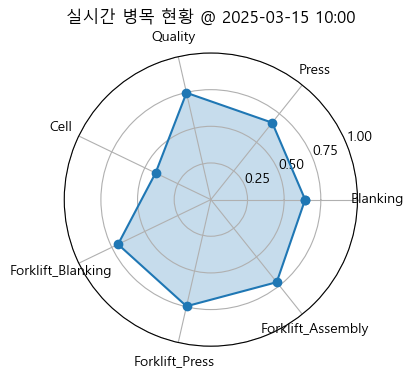

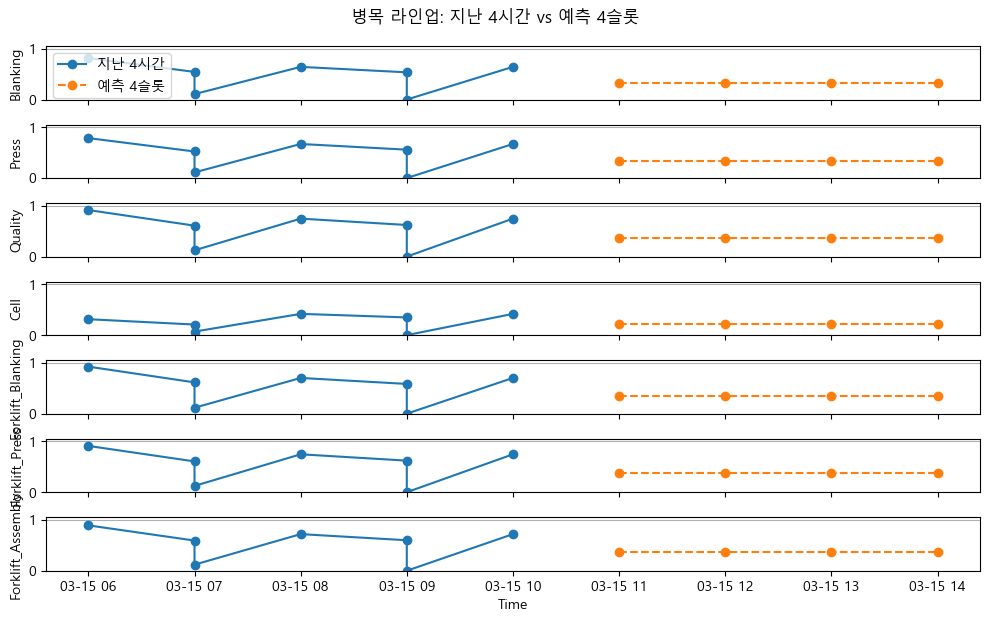

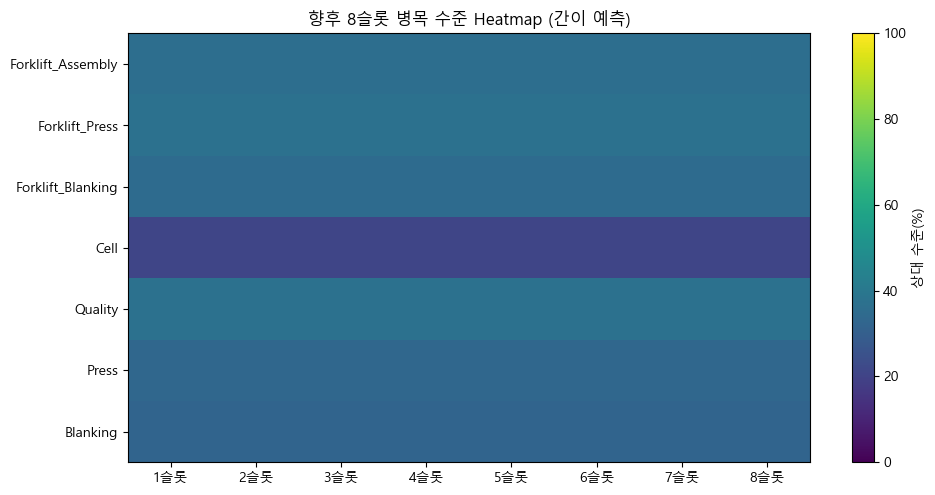

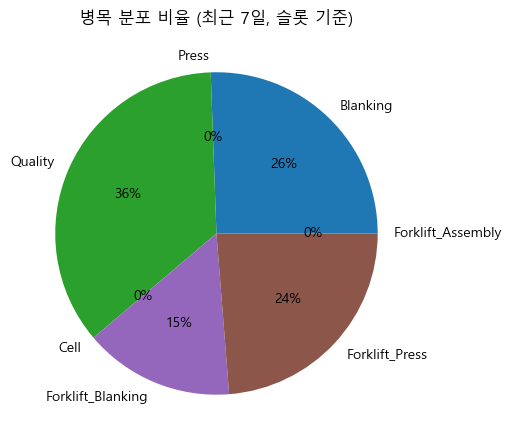


[향후 예상 병목]
- 2025-06-25 : Quality  (신뢰도: 46%)
- 2025-06-26 : Quality  (신뢰도: 48%)
- 2025-06-27 : Quality  (신뢰도: 48%)
- 2025-06-28 : Quality  (신뢰도: 48%)
- 2025-06-29 : Quality  (신뢰도: 48%)
- 2025-06-30 : Quality  (신뢰도: 48%)
- 2025-07-01 : Forklift_Press  (신뢰도: 66%)

[일별 상세 현황 (최근 7일)]
        날짜   생산량     리드타임          예측 병목  W1 Queue  P2 Queue    종합 가동률
2025-06-25 54633 0.454713        Quality    433.82    247.05 50.293883
2025-06-26 55842 0.439346        Quality    415.46    246.84 51.190419
2025-06-27 54818 0.430762        Quality    368.21    238.94 49.907876
2025-06-28 55261 0.415913        Quality    320.22    234.01 50.259327
2025-06-29 55647 0.413509        Quality    314.43    237.27 50.571053
2025-06-30 55270 0.463329        Quality    468.78    267.24 50.388364
2025-07-01 18751 0.515507 Forklift_Press    733.14    379.44 54.112667


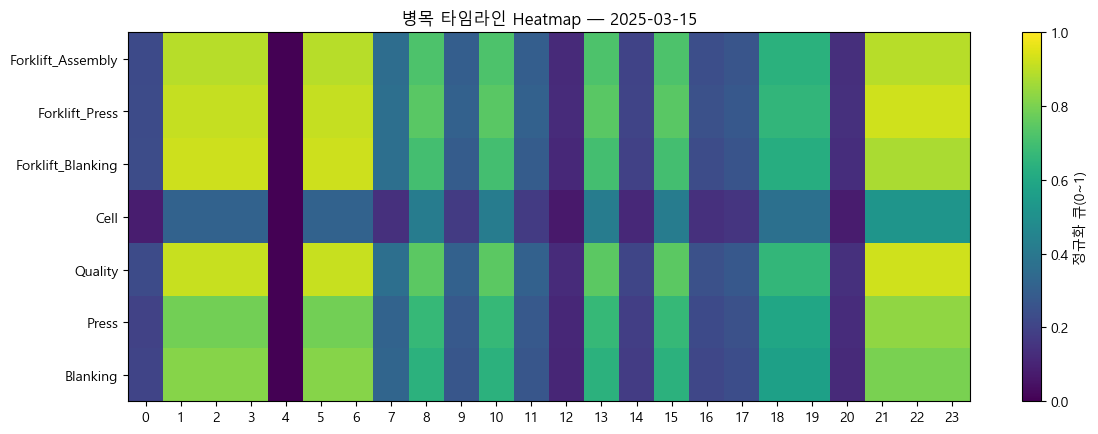

In [4]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 대시보드 생성 스크립트 (Paint/Cell=0 제외, Warehouse표시명=Cell)
- 입력: ./FinalResults_time_scheduled_20240101_20250630.csv
- 출력: 다양한 그래프/테이블 (화면 표시)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

# =========================
# 0) 기본 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

# 대시보드 기준 시각/날짜
TARGET_DATE = "2025-03-15"        # 하루 타임라인/레이더 기준일
TARGET_HOUR = "2025-03-15 10:00"  # 실시간 레이더/라인업 보드 기준 슬롯

# 병목 경보 조건
ALERT_THRESHOLD = 0.8   # 정규화 큐(0~1) 임계
ALERT_MIN_SLOTS = 5     # 연속 슬롯 수

# 폰트(환경에 맞게 하나만 살리세요)
mpl.rcParams["axes.unicode_minus"] = False
try:
    mpl.rcParams["font.family"] = "Malgun Gothic"  # Windows
except Exception:
    pass
# macOS: mpl.rcParams["font.family"] = "AppleGothic"
# Linux: mpl.rcParams["font.family"] = "NanumGothic"

# =========================
# 1) 데이터 로드/전처리
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
util_cols  = [c for c in df.columns if c.endswith("_Util")]
time_cols  = [c for c in df.columns if c.endswith("_Time")]
count_cols = [c for c in df.columns if c.startswith("c_Cell") or c == "c_TotalProducts"]

if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다. 입력 CSV를 확인하세요.")

# 공정 그룹핑(존재하는 컬럼만)
GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking_") or c.lower()=="blanking_queue"],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],   # 전부 0이면 제외
    "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],  # 전부 0이면 제외
    "Quality":    [c for c in queue_cols if c.lower().startswith("quality")],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
# 빈 그룹 제거
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if len(cols) > 0}

# 그룹별 합계/정규화 계산 + Paint/Cell=0 전체 제외
valid_groups = {}  # {GroupName: "Group_Qnorm"}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    # Paint/Cell 전부 0이면 제외(그 외 그룹도 0이면 제외해도 무방)
    if g in ("Paint", "Cell") and df[f"{g}_Qsum"].sum() == 0:
        continue
    # 완전 0이라면 시각화 의미가 없으므로 제외
    if df[f"{g}_Qsum"].sum() == 0:
        continue
    g_min, g_max = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
    if g_max > g_min:
        df[f"{g}_Qnorm"] = (df[f"{g}_Qsum"] - g_min) / (g_max - g_min)
    else:
        df[f"{g}_Qnorm"] = 0.0
    valid_groups[g] = f"{g}_Qnorm"

# 표시용 이름 매핑: Warehouse -> Cell (보이는 이름만 바꿈)
display_name = {g: ("Cell" if g == "Warehouse" else g) for g in valid_groups.keys()}
DISPLAY_GROUPS = [display_name[g] for g in valid_groups.keys()]
NORM_COLS = list(valid_groups.values())

# =========================
# 2) 경보(연속 임계 이상) 감지
# =========================
def detect_persistent_bottleneck(day_df, norm_col, thr=ALERT_THRESHOLD, min_slots=ALERT_MIN_SLOTS):
    x = (day_df[norm_col] >= thr).astype(int).values
    best = 0; cur = 0
    for v in x:
        cur = cur + 1 if v == 1 else 0
        best = max(best, cur)
    return (best >= min_slots), best

target_day = pd.Timestamp(TARGET_DATE).floor("D")
day_df = df[df["_date"] == target_day].copy()

alerts = []
for g, col in valid_groups.items():
    ok, streak = detect_persistent_bottleneck(day_df, col)
    if ok:
        alerts.append((display_name[g], streak))
if alerts:
    print("⚠️ 알림:", ", ".join([f"{g} {s} 슬롯 지속" for g, s in alerts]))
else:
    print("알림 없음(임계 이상 지속 병목 미감지)")

# =========================
# 3) 실시간 병목 현황 레이더
# =========================
def nearest_slot(ts: pd.Timestamp, series: pd.Series) -> int:
    return int(np.argmin(np.abs(series.values.astype("int64") - np.int64(ts.value))))

live_ts = pd.Timestamp(TARGET_HOUR)
if not day_df.empty:
    idx = nearest_slot(live_ts, day_df["Time_Now"])
    live_row = day_df.iloc[idx]
else:
    raise ValueError(f"{TARGET_DATE} 날짜 데이터가 비었습니다.")

rad_vals = [float(live_row[valid_groups[g]]) for g in valid_groups.keys()]
angles = np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False).tolist()
rad_vals += rad_vals[:1]
angles   += angles[:1]

fig = plt.figure(figsize=(4.2, 4.2))
ax = plt.subplot(111, polar=True)
ax.plot(angles, rad_vals, marker="o")
ax.fill(angles, rad_vals, alpha=0.25)
ax.set_xticks(np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False))
ax.set_xticklabels(DISPLAY_GROUPS)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_title(f"실시간 병목 현황 @ {live_ts.strftime('%Y-%m-%d %H:%M')}")
plt.tight_layout()
plt.show()

# =========================
# 4) 지난 4시간 / 예측 4슬롯 라인업 보드 (간단 이동평균 예측)
# =========================
past_hours = 4
fut_slots  = 4

board_df = day_df.copy()
board_df["t"] = board_df["Time_Now"]

sel = board_df[(board_df["t"] <= live_ts) &
               (board_df["t"] >= live_ts - pd.Timedelta(hours=past_hours))].copy()

# 슬롯 간격(가장 흔한 값) 추정
slot_deltas = (board_df["Time_End"] - board_df["Time_Now"]).dropna()
slot_delta = slot_deltas.mode().iloc[0] if not slot_deltas.empty else pd.Timedelta(minutes=60)

# 예측: 최근 2슬롯 평균을 앞으로 4슬롯 유지 (안전 fallback 포함)
hist = board_df[board_df["t"] <= live_ts].tail(2)
fut_rows = []
for k in range(1, fut_slots+1):
    row = {"t": live_ts + k*slot_delta}
    for g in valid_groups.keys():
        col = valid_groups[g]
        # 최근 값이 전부 NaN이면 0으로
        row[display_name[g]] = float(hist[col].mean()) if hist[col].notna().any() else 0.0
    fut_rows.append(row)
fut = pd.DataFrame(fut_rows)

fig, axes = plt.subplots(len(DISPLAY_GROUPS), 1, figsize=(10, 0.9*len(DISPLAY_GROUPS)), sharex=True)
if len(DISPLAY_GROUPS) == 1:
    axes = [axes]

for i, g in enumerate(valid_groups.keys()):
    g_name = display_name[g]
    axes[i].plot(sel["t"], sel[valid_groups[g]], marker="o", label="지난 4시간")
    axes[i].plot(fut["t"], fut[g_name], marker="o", linestyle="--", label="예측 4슬롯")
    axes[i].set_ylim(0, 1.05)
    axes[i].set_ylabel(g_name)
    axes[i].grid(True, axis="y")
axes[-1].set_xlabel("Time")
axes[0].legend(loc="upper left")
fig.suptitle("병목 라인업: 지난 4시간 vs 예측 4슬롯")
fig.tight_layout()
plt.show()

# =========================
# 5) 향후 8슬롯 병목 '수준' Heatmap (간이 예측 기반)
# =========================
# 위 예측(fut)에서 수준을 그대로 8슬롯로 확장(4슬롯 반복)
fut8 = []
for k in range(8):
    src = fut if k < len(fut) else fut.iloc[[-1]]
    row = {"slot": f"{k+1}"}  # k+1 슬롯 후
    for g in valid_groups.keys():
        row[display_name[g]] = float(src[display_name[g]].values[0])
    fut8.append(row)
fut8 = pd.DataFrame(fut8)
heat = fut8.set_index("slot")[DISPLAY_GROUPS].T  # (그룹 × 슬롯)

fig = plt.figure(figsize=(10, 2.6 + 0.35*len(DISPLAY_GROUPS)))
ax = plt.gca()
im = ax.imshow(100*heat.values, aspect="auto", origin="lower", vmin=0, vmax=100)
ax.set_yticks(range(len(heat.index))); ax.set_yticklabels(heat.index)
ax.set_xticks(range(len(heat.columns))); ax.set_xticklabels([f"{c}슬롯" for c in heat.columns])
plt.colorbar(im, label="상대 수준(%)")
ax.set_title("향후 8슬롯 병목 수준 Heatmap (간이 예측)")
plt.tight_layout()
plt.show()

# =========================
# 6) 병목 분포 비율(최근 7일) — 슬롯 단위 최상위 그룹 빈도 파이
# =========================
recent_days = sorted(df["_date"].unique())[-7:]
tmp = df[df["_date"].isin(recent_days)].copy()

slot_top = []
for _, r in tmp.iterrows():
    scores = {display_name[g]: r.get(valid_groups[g], 0.0) for g in valid_groups.keys()}
    slot_top.append(max(scores, key=scores.get) if scores else None)
slot_top = pd.Series([s for s in slot_top if s is not None]).value_counts().reindex(DISPLAY_GROUPS).fillna(0)

# 모든 값이 0이면 표시 생략
if slot_top.sum() > 0:
    fig = plt.figure(figsize=(5.2, 5.2))
    plt.pie(slot_top.values, labels=slot_top.index, autopct="%1.0f%%")
    plt.title("병목 분포 비율 (최근 7일, 슬롯 기준)")
    plt.tight_layout()
    plt.show()
else:
    print("[참고] 최근 7일 파이: 유의한 상위 그룹이 없어 생략합니다.")

# =========================
# 7) 향후 예상 병목(7일) — CSV의 '마지막 7일'을 미래로 가정
# =========================
future_days = sorted(df["_date"].unique())[-7:]
cards = []
for d in future_days:
    ddf = df[df["_date"] == d]
    if ddf.empty: 
        continue
    means = {display_name[g]: float(ddf[valid_groups[g]].mean()) for g in valid_groups.keys()}
    gtop = max(means, key=means.get) if means else None
    conf = int(round(100*means[gtop])) if gtop else 0
    cards.append((d.date(), gtop, conf))

print("\n[향후 예상 병목]")
for d, g, conf in cards:
    print(f"- {d} : {g}  (신뢰도: {conf}%)")

# =========================
# 8) 일별 상세 현황 표(최근 7일) — 생산/리드타임/예측병목/Queue지표
# =========================
count_cols  = [c for c in df.columns if c.startswith("c_Cell") or c == "c_TotalProducts"]
wait_cols   = [c for c in df.columns if c.endswith("Wait_Time")]
util_cols   = [c for c in df.columns if c.endswith("_Util")]
queue_sum_cols = [f"{g}_Qsum" for g in valid_groups.keys() if f"{g}_Qsum" in df.columns]

def day_summary(d):
    day_slice = df[df["_date"] == d]
    out = {}
    # 생산량
    if "c_TotalProducts" in day_slice.columns:
        out["생산량"] = int(day_slice["c_TotalProducts"].sum())
    elif count_cols:
        out["생산량"] = int(day_slice[count_cols].sum(axis=1).sum())
    else:
        out["생산량"] = np.nan
    # 리드타임(있으면)
    out["리드타임"] = float(day_slice[wait_cols].mean(axis=1).mean()) if wait_cols else np.nan
    # 종합 가동률(있으면)
    out["종합 가동률"] = float(day_slice[util_cols].mean(axis=1).mean()*100.0) if util_cols else np.nan
    # 예측 병목(정규화 평균 최댓값)
    means = {display_name[g]: float(day_slice[valid_groups[g]].mean()) for g in valid_groups.keys()}
    out["예측 병목"] = max(means, key=means.get) if means else None
    # Queue 대표값 2개(실제 합 Qsum 기준 상위 2개)
    real_means = {display_name[g]: float(day_slice[f"{g}_Qsum"].mean()) for g in valid_groups.keys() if f"{g}_Qsum" in day_slice.columns}
    top2 = sorted(real_means.items(), key=lambda x: x[1], reverse=True)[:2]
    out["W1 Queue"] = round(top2[0][1], 2) if len(top2) > 0 else np.nan
    out["P2 Queue"] = round(top2[1][1], 2) if len(top2) > 1 else np.nan
    return out

recent_days = sorted(df["_date"].unique())[-7:]
rows = []
for d in recent_days:
    s = day_summary(d)
    s["날짜"] = d.date()
    rows.append(s)

table = pd.DataFrame(rows)[["날짜", "생산량", "리드타임", "예측 병목", "W1 Queue", "P2 Queue", "종합 가동률"]]
print("\n[일별 상세 현황 (최근 7일)]")
print(table.to_string(index=False))

# =========================
# 9) 하루 병목 타임라인 Heatmap (공정 × Hour)
# =========================
one = df[df["_date"] == target_day].copy()
if one.empty:
    print(f"[참고] {target_day.date()} 하루 데이터가 없어 타임라인 생략.")
else:
    one["hour"] = one["Time_Now"].dt.hour
    hours_sorted = sorted(one["hour"].unique())
    pivot = pd.DataFrame(index=[display_name[g] for g in valid_groups.keys()],
                         columns=hours_sorted, dtype=float)
    for g in valid_groups.keys():
        for h in hours_sorted:
            pivot.loc[display_name[g], h] = one.loc[one["hour"] == h, valid_groups[g]].mean()
    pivot = pivot.fillna(0.0)

    fig = plt.figure(figsize=(12, 2 + 0.35*len(pivot.index)))
    ax = plt.gca()
    im = ax.imshow(pivot.values, aspect="auto", origin="lower", vmin=0, vmax=1)
    ax.set_yticks(range(len(pivot.index))); ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels(pivot.columns)
    plt.colorbar(im, label="정규화 큐(0~1)")
    ax.set_title(f"병목 타임라인 Heatmap — {target_day.date()}")
    plt.tight_layout()
    plt.show()

알림 없음(임계 이상 지속 병목 미감지)


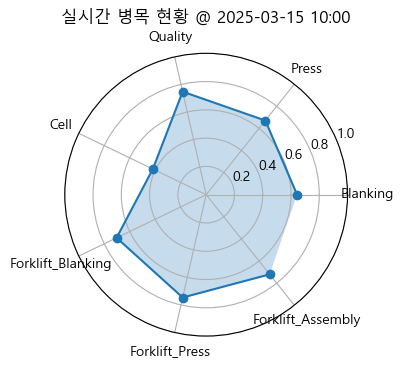

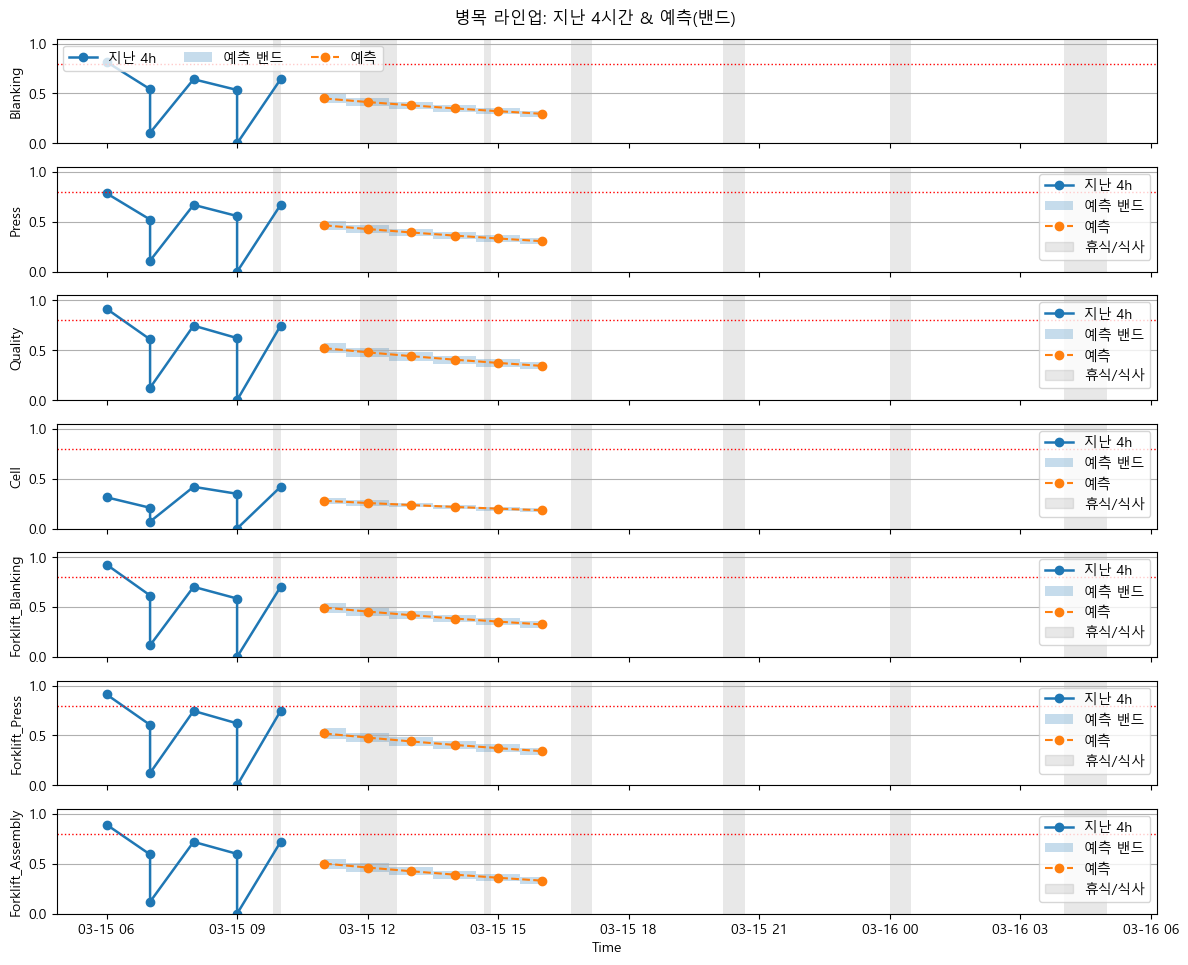

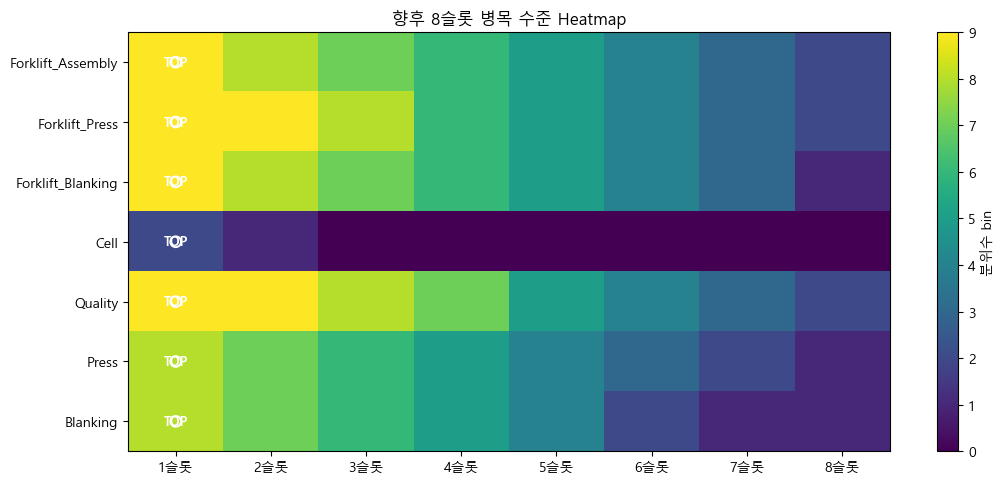

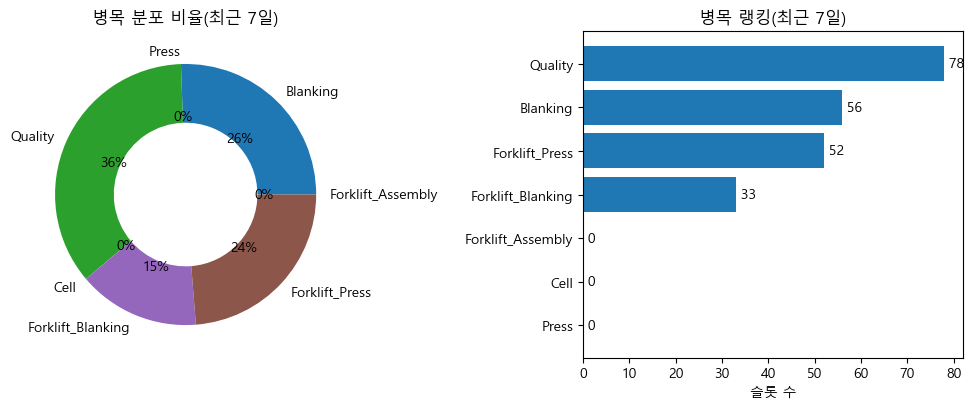


[일별 상세 현황 (최근 7일)]
        날짜   생산량     리드타임          예측 병목  W1 Queue  P2 Queue    종합 가동률
2025-06-25 54633 0.454713        Quality    433.82    247.05 50.293883
2025-06-26 55842 0.439346        Quality    415.46    246.84 51.190419
2025-06-27 54818 0.430762        Quality    368.21    238.94 49.907876
2025-06-28 55261 0.415913        Quality    320.22    234.01 50.259327
2025-06-29 55647 0.413509        Quality    314.43    237.27 50.571053
2025-06-30 55270 0.463329        Quality    468.78    267.24 50.388364
2025-07-01 18751 0.515507 Forklift_Press    733.14    379.44 54.112667


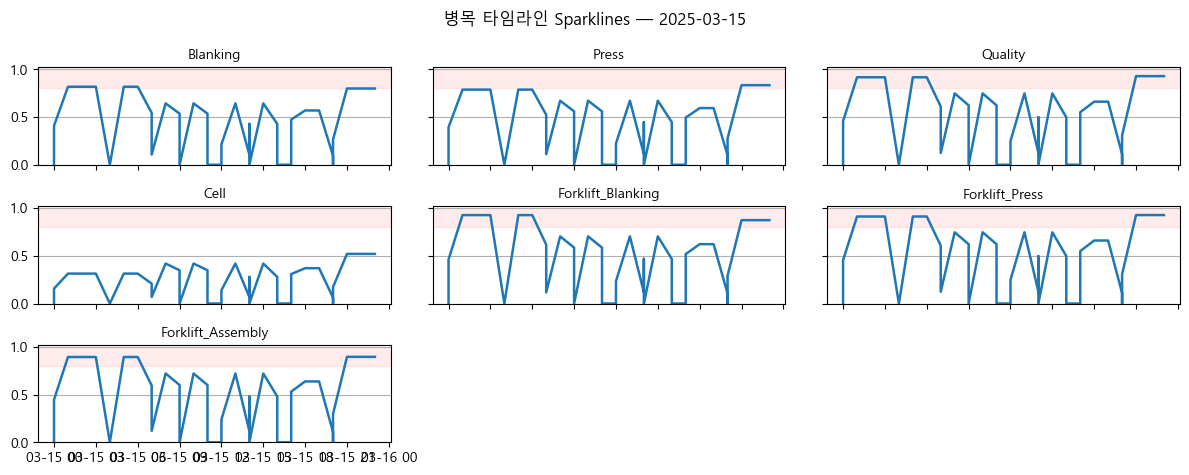

In [7]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 '보기 좋은' 대시보드
- Paint/Cell=0 전체 제외, Warehouse 표기는 "Cell"
- 라인업: 예측 밴드(EMA+감쇠) + 임계선 + 휴게/식사 음영
- 예측 히트맵: quantile 정규화(옵션) + 핫스팟 라벨
- 분포: 도넛 파이 + 가로 랭킹 바
- 타임라인: 히트맵 or 소형 스파크라인 그리드 선택
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"         # 하루 기준일
TARGET_HOUR = "2025-03-15 10:00"   # 레이더/라인업 기준 시각

ALERT_THRESHOLD = 0.8
ALERT_MIN_SLOTS = 5

# 예측 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 4
FUT_LINEUP_SLOTS = 6     # 라인업 예측 길이
FUT_HEAT_SLOTS   = 8     # 히트맵 예측 길이

# 히트맵 스케일: "linear" or "quantile"
HEATMAP_SCALE = "quantile"
N_QUANT_BINS  = 10

# 타임라인 표현: "heatmap" or "sparklines"
TIMELINE_STYLE = "sparklines"

# 스케줄 블록(휴게/식사 음영용) — 07:50 ~ 다음날 07:40 창
SCHEDULE_BLOCKS = [
    ("07:50","09:50","주간"),
    ("09:50","10:00","휴식"),
    ("10:00","11:50","주간"),
    ("11:50","12:40","중식"),
    ("12:40","14:40","주간"),
    ("14:40","14:50","휴식"),
    ("14:50","16:40","주간"),
    ("16:40","17:10","석식"),
    ("17:10","20:10","잔업"),
    ("20:10","20:40","휴식"),
    ("20:40","00:00","야간"),
    ("00:00","00:30","야식"),
    ("00:30","04:00","야간"),
    ("04:00","05:00","휴식"),
    ("05:00","07:40","야간"),
]
REST_LABELS = {"휴식","중식","석식","야식"}

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def build_schedule_for_plot(day: pd.Timestamp) -> pd.DataFrame:
    day = pd.Timestamp(day).floor("D")
    anchor_start = pd.Timestamp(day.year,day.month,day.day,7,50)
    anchor_end   = anchor_start + pd.Timedelta(hours=23, minutes=50)  # 다음날 07:40
    rows=[]
    for sstr, estr, label in SCHEDULE_BLOCKS:
        sh,sm = map(int, sstr.split(":"))
        eh,em = map(int, estr.split(":"))
        s = pd.Timestamp(day.year,day.month,day.day,sh,sm)
        e = pd.Timestamp(day.year,day.month,day.day,eh,em)
        if (sh,sm) < (7,50): s += pd.Timedelta(days=1)
        if (eh,em) < (7,50) or e <= s: e += pd.Timedelta(days=1)
        s = max(s, anchor_start); e = min(e, anchor_end)
        if e > s: rows.append({"start":s,"end":e,"label":label})
    return pd.DataFrame(rows)

def rest_intervals(day: pd.Timestamp):
    sch = build_schedule_for_plot(day)
    rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]].sort_values("start")
    merged=[]
    if rest.empty: return merged
    cur_s, cur_e = rest.iloc[0]["start"], rest.iloc[0]["end"]
    for _, r in rest.iloc[1:].iterrows():
        s, e = r["start"], r["end"]
        if s <= cur_e: cur_e = max(cur_e, e)
        else: merged.append((cur_s, cur_e)); cur_s, cur_e = s, e
    merged.append((cur_s, cur_e))
    return merged

def shade_rest(ax, intervals, label="휴식/식사"):
    if not intervals: return
    for s,e in intervals:
        ax.axvspan(s, e, color="grey", alpha=0.18, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    if label not in labels:
        handles.append(Patch(color="grey", alpha=0.18, label=label))
        ax.legend(handles=handles, loc="best")

def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """시퀀스 → EMA 마지막값 기준 다단계 예측(감쇠 적용)"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    out=[]
    for k in range(steps):
        out.append(float(ema * (decay**k)))
    return out

# =========================
# 3) 데이터 로드/그룹 정규화
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다.")

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking_") or c.lower()=="blanking_queue"],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],   # 전부 0이면 제외
    "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],  # 전부 0이면 제외
    "Quality":    [c for c in queue_cols if c.lower().startswith("quality")],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

# 그룹 합/정규화 + Paint/Cell=0 제외
valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum() == 0:
        continue
    if df[f"{g}_Qsum"].sum() == 0:
        continue
    gmin, gmax = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
    df[f"{g}_Qnorm"] = 0.0 if gmax==gmin else (df[f"{g}_Qsum"]-gmin)/(gmax-gmin)
    valid_groups[g] = f"{g}_Qnorm"

# 화면 표기: Warehouse → Cell
display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}
DISPLAY_GROUPS = [display_name[g] for g in valid_groups]
NORM_COLS = list(valid_groups.values())

# =========================
# 4) 경보
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)

day_df = df[df["_date"]==TDAY].copy()
def detect_alert(day_df, col, thr=ALERT_THRESHOLD, min_run=ALERT_MIN_SLOTS):
    x = (day_df[col] >= thr).astype(int).values
    run=best=0
    for v in x:
        run = run+1 if v else 0
        best = max(best, run)
    return best>=min_run, best

alerts=[]
for g,col in valid_groups.items():
    ok,streak = detect_alert(day_df, col)
    if ok: alerts.append(f"{display_name[g]} {streak}슬롯 지속 ≥{ALERT_THRESHOLD}")
print("알림 없음(임계 이상 지속 병목 미감지)" if not alerts else "⚠️ " + " ; ".join(alerts))

# =========================
# 5) 레이더 (그대로)
# =========================
if not day_df.empty:
    idx = int(np.argmin(np.abs(day_df["Time_Now"].values.astype("datetime64[ns]").astype("int64")
                         - np.int64(THOUR.value))))
    live_row = day_df.iloc[idx]
    vals = [float(live_row[valid_groups[g]]) for g in valid_groups]
    labels = DISPLAY_GROUPS
    theta = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    vals = np.clip(vals,0,1)
    fig = plt.figure(figsize=(4.1,4.1)); ax = plt.subplot(111, polar=True)
    ax.plot(theta, vals, marker="o"); ax.fill(theta, vals, alpha=0.25)
    ax.set_thetagrids(theta*180/np.pi, labels); ax.set_rlim(0,1)
    ax.set_title(f"실시간 병목 현황 @ {THOUR:%Y-%m-%d %H:%M}")
    fig.tight_layout(); plt.show()

# =========================
# 6) 라인업 보드 — 예측 밴드 + 임계선 + 휴게 음영
# =========================
board = day_df.copy()
board["t"] = board["Time_Now"]
sel = board[(board["t"]<=THOUR)&(board["t"]>=THOUR-pd.Timedelta(hours=PAST_HOURS))].copy()

slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# 예측 밴드: EMA * decay, 불확도 ±10% 밴드(시각 강조)
hist = board[board["t"] <= THOUR].tail(8)

# 1) 예측 타임스탬프를 먼저 만들고 DataFrame 생성
pred_times = [THOUR + k * slot_delta for k in range(1, FUT_LINEUP_SLOTS + 1)]
pred = pd.DataFrame({"t": pred_times})

# 2) 각 공정별로 EMA 예측을 계산해 컬럼으로 할당
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    yhat = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)  # 길이 = FUT_LINEUP_SLOTS
    pred[display_name[g]] = yhat

fig, axes = plt.subplots(len(DISPLAY_GROUPS), 1, figsize=(12, 1.4*len(DISPLAY_GROUPS)), sharex=True)
if len(DISPLAY_GROUPS)==1: axes=[axes]
rests = rest_intervals(TDAY)
for i,g in enumerate(valid_groups):
    name = display_name[g]; col = valid_groups[g]
    ax = axes[i]
    # 과거
    ax.plot(sel["t"], sel[col], marker="o", lw=1.8, label="지난 4h")
    # 예측 밴드(±10%)
    yh = pred[name].values if isinstance(pred[name], np.ndarray) else pred[name]
    yh = np.asarray(yh, float)
    lo, hi = np.clip(yh*0.9,0,1), np.clip(yh*1.1,0,1)
    ax.fill_between(pred["t"], lo, hi, alpha=0.25, step="mid", label="예측 밴드")
    ax.plot(pred["t"], np.clip(yh,0,1), linestyle="--", marker="o", label="예측")
    # 임계선
    ax.axhline(ALERT_THRESHOLD, color="red", lw=1, ls=":")
    # 휴식 음영
    shade_rest(ax, rests)
    ax.set_ylim(0,1.05); ax.set_ylabel(name); ax.grid(True, axis="y")
axes[-1].set_xlabel("Time")
axes[0].legend(ncol=3, loc="upper left")
fig.suptitle("병목 라인업: 지난 4시간 & 예측(밴드)")
fig.tight_layout(); plt.show()

# =========================
# 7) 향후 8슬롯 히트맵 — quantile 옵션 + 핫스팟 라벨
# =========================
fut_ts = [THOUR + (k+1)*slot_delta for k in range(FUT_HEAT_SLOTS)]
pred8 = pd.DataFrame({"t": fut_ts})
for g,col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred8[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_HEAT_SLOTS, DECAY)
heat = pred8.drop(columns=["t"]).T  # (group × slot)

if HEATMAP_SCALE == "quantile":
    # 0~1 범위에 대해 분위수 binning -> 시각적 대비 개선
    flat = heat.values.ravel()
    qs = np.quantile(flat, np.linspace(0,1,N_QUANT_BINS+1))
    def qbin(x): 
        return np.searchsorted(qs, x, side="right")-1
    viz = np.vectorize(qbin)(heat.values)
    vmin, vmax = 0, N_QUANT_BINS-1
    cmap = "viridis"
    data_for_color = viz
else:
    viz = heat.values
    vmin, vmax = 0, 1
    cmap = "viridis"
    data_for_color = viz

fig = plt.figure(figsize=(11, 2.5 + 0.35*len(heat.index)))
ax = plt.gca()
im = ax.imshow(data_for_color, aspect="auto", origin="lower", vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_yticks(range(len(heat.index))); ax.set_yticklabels(heat.index)
ax.set_xticks(range(heat.shape[1])); ax.set_xticklabels([f"{k+1}슬롯" for k in range(heat.shape[1])])
cb = plt.colorbar(im, ax=ax); cb.set_label("상대 수준(%)" if HEATMAP_SCALE!="quantile" else "분위수 bin")
ax.set_title("향후 8슬롯 병목 수준 Heatmap")
# 핫스팟 라벨(각 행 최대치에 마커)
for i in range(heat.shape[0]):
    j = int(np.argmax(heat.values[i]))
    ax.scatter(j, i, s=60, edgecolor="white", facecolor="none", lw=1.4)
    ax.text(j, i, "TOP", color="white", ha="center", va="center", fontsize=9, weight="bold")
plt.tight_layout(); plt.show()

# =========================
# 8) 분포 — 도넛 & 랭킹 바
# =========================
recent_days = sorted(df["_date"].unique())[-7:]
tmp = df[df["_date"].isin(recent_days)]
slot_top=[]
for _, r in tmp.iterrows():
    scores = {display_name[g]: r[valid_groups[g]] for g in valid_groups}
    if scores: slot_top.append(max(scores, key=scores.get))
ser = pd.Series(slot_top).value_counts().reindex(heat.index if 'heat' in locals() else DISPLAY_GROUPS).fillna(0)

if ser.sum()>0:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.2))
    # 도넛
    wedges, texts, autotexts = ax1.pie(ser.values, labels=ser.index, autopct="%1.0f%%",
                                       wedgeprops=dict(width=0.45))
    ax1.set_title("병목 분포 비율(최근 7일)")
    # 랭킹 바
    s2 = ser.sort_values()
    ax2.barh(s2.index, s2.values)
    ax2.set_title("병목 랭킹(최근 7일)")
    ax2.set_xlabel("슬롯 수")
    for y,v in enumerate(s2.values):
        ax2.text(v, y, f" {int(v)}", va="center")
    plt.tight_layout(); plt.show()
else:
    print("[참고] 최근 7일 분포: 유의한 값이 없어 생략.")

# =========================
# 9) 일별 상세 표
# =========================
count_cols = [c for c in df.columns if c.startswith("c_Cell") or c=="c_TotalProducts"]
wait_cols  = [c for c in df.columns if c.endswith("Wait_Time")]
util_cols  = [c for c in df.columns if c.endswith("_Util")]

def summarize_day(d):
    dd = df[df["_date"]==d]
    out={"날짜": d.date()}
    out["생산량"] = (int(dd["c_TotalProducts"].sum()) if "c_TotalProducts" in dd.columns
                    else (int(dd[count_cols].sum(axis=1).sum()) if count_cols else np.nan))
    out["리드타임"] = float(dd[wait_cols].mean(axis=1).mean()) if wait_cols else np.nan
    out["종합 가동률"] = float(dd[util_cols].mean(axis=1).mean()*100) if util_cols else np.nan
    means = {display_name[g]: float(dd[valid_groups[g]].mean()) for g in valid_groups}
    out["예측 병목"] = (max(means, key=means.get) if means else None)
    # 대표 Queue
    real_means = {display_name[g]: float(dd[f"{g}_Qsum"].mean()) for g in valid_groups if f"{g}_Qsum" in dd}
    t2 = sorted(real_means.items(), key=lambda x: x[1], reverse=True)[:2]
    out["W1 Queue"] = round(t2[0][1],2) if len(t2)>0 else np.nan
    out["P2 Queue"] = round(t2[1][1],2) if len(t2)>1 else np.nan
    return out

rows=[summarize_day(d) for d in recent_days]
table=pd.DataFrame(rows, columns=["날짜","생산량","리드타임","예측 병목","W1 Queue","P2 Queue","종합 가동률"])
print("\n[일별 상세 현황 (최근 7일)]")
print(table.to_string(index=False))

# =========================
# 10) 하루 타임라인 — 히트맵 or 스파크라인
# =========================
one = df[df["_date"]==TDAY].copy()
if one.empty:
    print(f"[참고] {TDAY.date()} 데이터 없음.")
else:
    if TIMELINE_STYLE == "heatmap":
        one["hour"]=one["Time_Now"].dt.hour
        hours=sorted(one["hour"].unique())
        piv = pd.DataFrame(index=[display_name[g] for g in valid_groups], columns=hours)
        for g in valid_groups:
            for h in hours:
                piv.loc[display_name[g], h] = one.loc[one["hour"]==h, valid_groups[g]].mean()
        piv=piv.astype(float).fillna(0.0)
        fig=plt.figure(figsize=(12, 2.2+0.35*len(piv.index))); ax=plt.gca()
        im=ax.imshow(piv.values, aspect="auto", origin="lower", vmin=0, vmax=1, cmap="viridis")
        ax.set_yticks(range(len(piv.index))); ax.set_yticklabels(piv.index)
        ax.set_xticks(range(len(piv.columns))); ax.set_xticklabels(piv.columns)
        plt.colorbar(im, label="정규화 큐(0~1)")
        ax.set_title(f"병목 타임라인 Heatmap — {TDAY.date()}")
        plt.tight_layout(); plt.show()
    else:
        # 스파크라인 그리드
        groups = list(valid_groups.keys())
        n = len(groups)
        cols = 3
        rows = int(np.ceil(n/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(12, 1.6*rows), sharex=True, sharey=True)
        axes = axes.ravel()
        for i,g in enumerate(groups):
            ax = axes[i]
            ax.plot(one["Time_Now"], one[valid_groups[g]], lw=1.8)
            ax.set_title(display_name[g], fontsize=10)
            ax.grid(True, axis="y"); ax.set_ylim(0,1.02)
            # 임계 영역 하이라이트
            ax.axhspan(ALERT_THRESHOLD, 1.0, color="red", alpha=0.08)
        for j in range(i+1, len(axes)): axes[j].axis("off")
        fig.suptitle(f"병목 타임라인 Sparklines — {TDAY.date()}")
        fig.tight_layout(); plt.show()

알림 없음


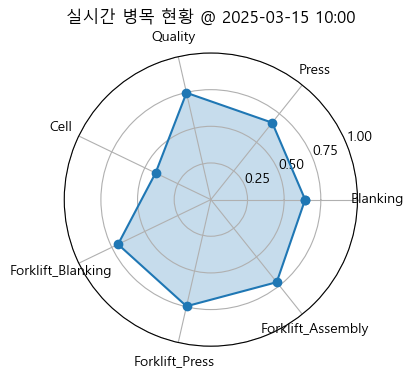

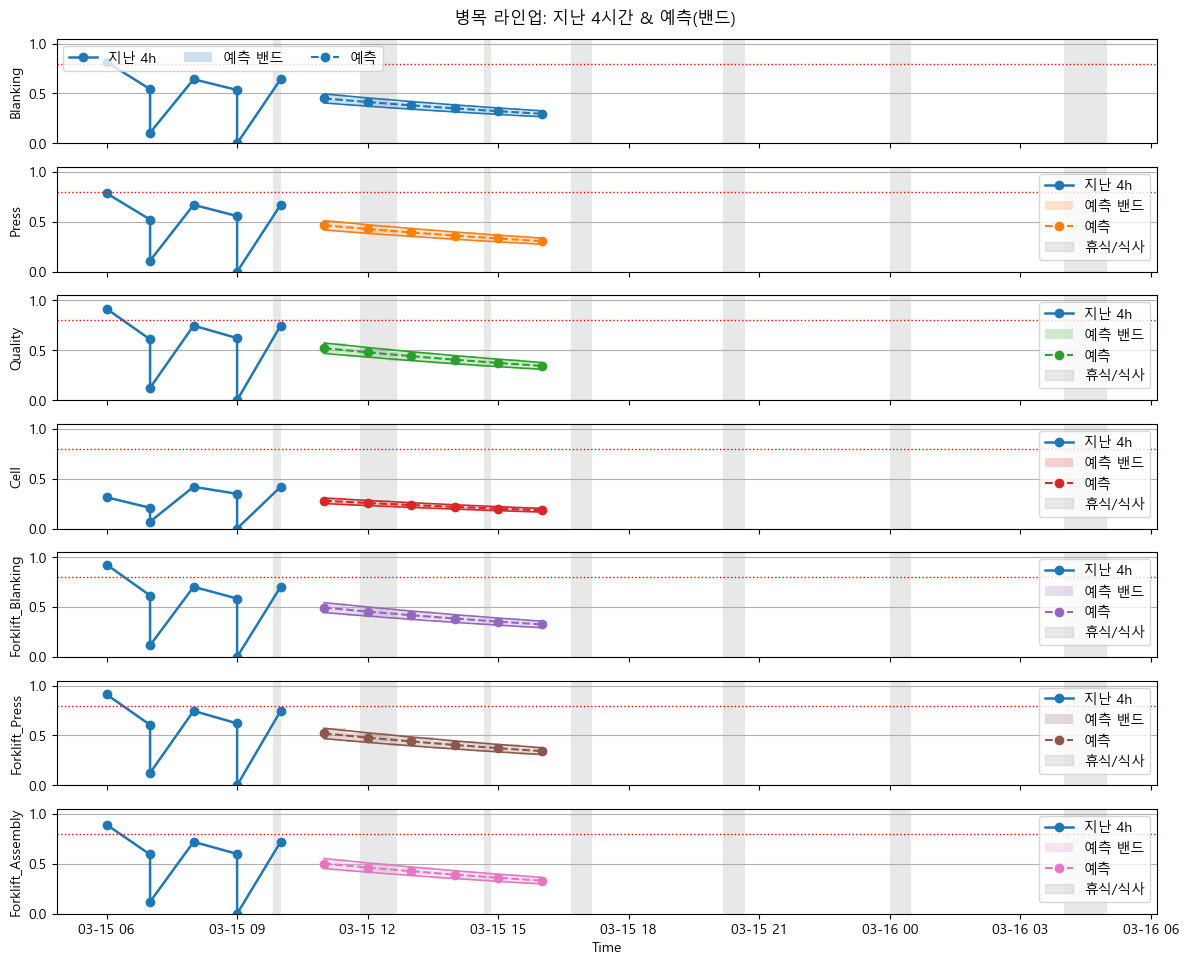

In [9]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 '보기 좋은' 대시보드
- Paint/Cell=0 전체 제외, Warehouse 표기는 "Cell"
- 라인업: 예측 밴드(EMA+감쇠) + 임계선 + 휴게/식사 음영 + 밴드 테두리
- 예측 히트맵: quantile 정규화(옵션) + 핫스팟 라벨
- 분포: 도넛 파이 + 가로 랭킹 바
- 타임라인: 히트맵 or 소형 스파크라인 그리드 선택
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"         # 하루 기준일
TARGET_HOUR = "2025-03-15 10:00"   # 레이더/라인업 기준 시각

ALERT_THRESHOLD = 0.8
ALERT_MIN_SLOTS = 5

# 예측 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 4
FUT_LINEUP_SLOTS = 6     # 라인업 예측 길이
FUT_HEAT_SLOTS   = 8     # 히트맵 예측 길이

# 히트맵 스케일: "linear" or "quantile"
HEATMAP_SCALE = "quantile"
N_QUANT_BINS  = 10

# 타임라인 표현: "heatmap" or "sparklines"
TIMELINE_STYLE = "sparklines"

# 스케줄 블록(휴게/식사 음영용)
SCHEDULE_BLOCKS = [
    ("07:50","09:50","주간"),
    ("09:50","10:00","휴식"),
    ("10:00","11:50","주간"),
    ("11:50","12:40","중식"),
    ("12:40","14:40","주간"),
    ("14:40","14:50","휴식"),
    ("14:50","16:40","주간"),
    ("16:40","17:10","석식"),
    ("17:10","20:10","잔업"),
    ("20:10","20:40","휴식"),
    ("20:40","00:00","야간"),
    ("00:00","00:30","야식"),
    ("00:30","04:00","야간"),
    ("04:00","05:00","휴식"),
    ("05:00","07:40","야간"),
]
REST_LABELS = {"휴식","중식","석식","야식"}

# =========================
# 1) 폰트
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def build_schedule_for_plot(day: pd.Timestamp) -> pd.DataFrame:
    day = pd.Timestamp(day).floor("D")
    anchor_start = pd.Timestamp(day.year,day.month,day.day,7,50)
    anchor_end   = anchor_start + pd.Timedelta(hours=23, minutes=50)
    rows=[]
    for sstr, estr, label in SCHEDULE_BLOCKS:
        sh,sm = map(int, sstr.split(":"))
        eh,em = map(int, estr.split(":"))
        s = pd.Timestamp(day.year,day.month,day.day,sh,sm)
        e = pd.Timestamp(day.year,day.month,day.day,eh,em)
        if (sh,sm) < (7,50): s += pd.Timedelta(days=1)
        if (eh,em) < (7,50) or e <= s: e += pd.Timedelta(days=1)
        s = max(s, anchor_start); e = min(e, anchor_end)
        if e > s: rows.append({"start":s,"end":e,"label":label})
    return pd.DataFrame(rows)

def rest_intervals(day: pd.Timestamp):
    sch = build_schedule_for_plot(day)
    rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]].sort_values("start")
    merged=[]
    if rest.empty: return merged
    cur_s, cur_e = rest.iloc[0]["start"], rest.iloc[0]["end"]
    for _, r in rest.iloc[1:].iterrows():
        s, e = r["start"], r["end"]
        if s <= cur_e: cur_e = max(cur_e, e)
        else: merged.append((cur_s, cur_e)); cur_s, cur_e = s, e
    merged.append((cur_s, cur_e))
    return merged

def shade_rest(ax, intervals, label="휴식/식사"):
    if not intervals: return
    for s,e in intervals:
        ax.axvspan(s, e, color="grey", alpha=0.18, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    if label not in labels:
        handles.append(Patch(color="grey", alpha=0.18, label=label))
        ax.legend(handles=handles, loc="best")

def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    out=[]
    for k in range(steps):
        out.append(float(ema * (decay**k)))
    return out

# =========================
# 3) 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking_") or c.lower()=="blanking_queue"],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],
    "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],
    "Quality":    [c for c in queue_cols if c.lower().startswith("quality")],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum() == 0: continue
    if df[f"{g}_Qsum"].sum() == 0: continue
    gmin, gmax = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
    df[f"{g}_Qnorm"] = 0.0 if gmax==gmin else (df[f"{g}_Qsum"]-gmin)/(gmax-gmin)
    valid_groups[g] = f"{g}_Qnorm"

display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}
DISPLAY_GROUPS = [display_name[g] for g in valid_groups]

# =========================
# 4) 경보
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()

def detect_alert(day_df, col, thr=ALERT_THRESHOLD, min_run=ALERT_MIN_SLOTS):
    x = (day_df[col] >= thr).astype(int).values
    run=best=0
    for v in x:
        run = run+1 if v else 0
        best = max(best, run)
    return best>=min_run, best

alerts=[]
for g,col in valid_groups.items():
    ok,streak = detect_alert(day_df, col)
    if ok: alerts.append(f"{display_name[g]} {streak}슬롯 지속 ≥{ALERT_THRESHOLD}")
print("알림 없음" if not alerts else "⚠️ " + " ; ".join(alerts))

# =========================
# 5) 레이더
# =========================
def nearest_slot(ts: pd.Timestamp, series: pd.Series) -> int:
    return int(np.argmin(np.abs(series.values.astype("int64") - np.int64(ts.value))))

live_ts = pd.Timestamp(TARGET_HOUR)
if not day_df.empty:
    idx = nearest_slot(live_ts, day_df["Time_Now"])
    live_row = day_df.iloc[idx]
else:
    raise ValueError(f"{TARGET_DATE} 날짜 데이터가 비었습니다.")

rad_vals = [float(live_row[valid_groups[g]]) for g in valid_groups.keys()]
angles = np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False).tolist()
rad_vals += rad_vals[:1]
angles   += angles[:1]

fig = plt.figure(figsize=(4.2, 4.2))
ax = plt.subplot(111, polar=True)
ax.plot(angles, rad_vals, marker="o")
ax.fill(angles, rad_vals, alpha=0.25)
ax.set_xticks(np.linspace(0, 2*np.pi, len(DISPLAY_GROUPS), endpoint=False))
ax.set_xticklabels(DISPLAY_GROUPS)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_title(f"실시간 병목 현황 @ {live_ts.strftime('%Y-%m-%d %H:%M')}")
plt.tight_layout()
plt.show()

# =========================
# 6) 라인업 보드 — 외곽선 추가
# =========================
board = day_df.copy(); board["t"] = board["Time_Now"]
sel = board[(board["t"]<=THOUR)&(board["t"]>=THOUR-pd.Timedelta(hours=PAST_HOURS))].copy()
slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0]

hist = board[board["t"] <= THOUR].tail(8)
pred_times = [THOUR + k*slot_delta for k in range(1, FUT_LINEUP_SLOTS+1)]
pred = pd.DataFrame({"t": pred_times})
for g,col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

fig, axes = plt.subplots(len(DISPLAY_GROUPS), 1, figsize=(12, 1.4*len(DISPLAY_GROUPS)), sharex=True)
if len(DISPLAY_GROUPS)==1: axes=[axes]
rests = rest_intervals(TDAY)

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,g in enumerate(valid_groups):
    name = display_name[g]; col = valid_groups[g]; ax = axes[i]
    # 과거
    ax.plot(sel["t"], sel[col], marker="o", lw=1.8, label="지난 4h")
    # 예측 값
    yh = np.asarray(pred[name], float)
    lo, hi = np.clip(yh*0.9,0,1), np.clip(yh*1.1,0,1)
    color = palette[i % len(palette)]
    # 예측 밴드
    ax.fill_between(pred["t"], lo, hi, facecolor=color, alpha=0.22, step="mid", label="예측 밴드")
    ax.plot(pred["t"], lo, color=color, lw=1.2)
    ax.plot(pred["t"], hi, color=color, lw=1.2)
    ax.plot(pred["t"], np.clip(yh,0,1), linestyle="--", marker="o", color=color, label="예측")
    ax.axhline(ALERT_THRESHOLD, color="red", lw=1, ls=":")
    shade_rest(ax, rests)
    ax.set_ylim(0,1.05); ax.set_ylabel(name); ax.grid(True, axis="y")

axes[-1].set_xlabel("Time")
axes[0].legend(ncol=3, loc="upper left")
fig.suptitle("병목 라인업: 지난 ㅁ4시간 & 예측(밴드)")
fig.tight_layout(); plt.show()

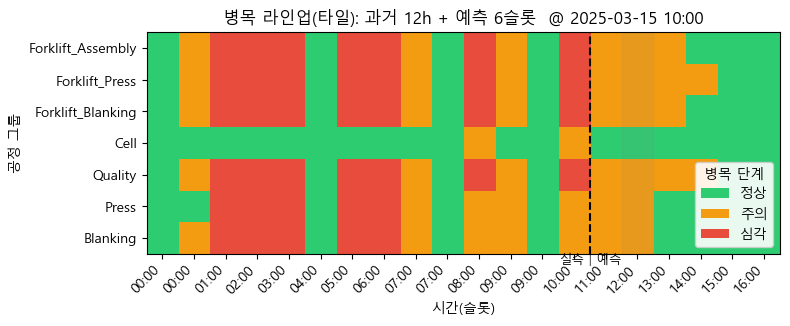

In [10]:
# =========================
# 6) 라인업 보드 — 타일(사각칸)형: 실측+예측 결합, 단계색(정상/주의/심각)
# =========================
# 보기 창: 과거 최소 12시간(혹은 PAST_HOURS 중 큰 값) + 예측 FUT_LINEUP_SLOTS
WINDOW_HOURS = max(PAST_HOURS, 12)

board = day_df.copy()
board["t"] = board["Time_Now"]

# 슬롯 간격(모드) 추정
slot_delta = (board["Time_End"] - board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# ==== 6-1) 실측 구간(과거 WINDOW_HOURS) 추출 ====
past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=WINDOW_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# ==== 6-2) 예측(EMA+감쇠) 구간 생성 ====
hist = board[board["t"] <= THOUR].tail(8)
pred_times = [THOUR + (k+1)*slot_delta for k in range(FUT_LINEUP_SLOTS)]
pred = pd.DataFrame({"t": pred_times})
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)  # 0~1 범위 가정

# ==== 6-3) 실측+예측 타임라인 결합 ====
# 행 = 그룹, 열 = 시간슬롯 (실측 뒤에 예측 이어붙임)
timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M = len(groups); N = len(timeline_times)

# 값 매트릭스(정규화 큐): 실측은 컬럼에서 읽고, 예측은 pred 사용
mat = np.zeros((M, N), dtype=float)
for i, g in enumerate(groups):
    col = valid_groups[g]
    # 실측
    mat[i, :len(past)] = past[col].astype(float).fillna(0.0).clip(0, 1).values
    # 예측
    yhat = np.asarray(pred[display_name[g]], float)
    mat[i, len(past):] = np.clip(yhat, 0, 1)

# ==== 6-4) 단계화(카테고리) — 정상/주의/심각 ====
# 규칙은 필요 시 바꾸세요
# [0.0, 0.4) = 정상(초록) / [0.4, 0.7) = 주의(주황) / [0.7, 1.0] = 심각(진한 빨강)
bins = [0.0, 0.4, 0.7, 1.0 + 1e-9]
labels = ["정상", "주의", "심각"]
colors = ["#2ecc71", "#f39c12", "#e74c3c"]  # 초록/주황/빨강
cats = np.digitize(mat, bins, right=False) - 1  # 0,1,2

# ==== 6-5) 그리드(정사각 타일) 시각화 ====
fig_h = max(3.0, 0.6 * M)      # 그룹 수에 따른 높이
fig_w = max(8.0, 0.35 * N)     # 슬롯 수에 따른 너비
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(-0.5, 3.5, 1.0), cmap.N)

im = ax.imshow(cats, aspect='equal', cmap=cmap, norm=norm, origin='lower')  # aspect='equal' → 정사각형

# y축: 그룹명(보이는 이름으로)
ax.set_yticks(np.arange(M))
ax.set_yticklabels([display_name[g] for g in groups])

# x축: 시간 라벨 (많으면 간격 샘플링)
xticks = np.arange(N)
# 최대 12개 정도만 보이도록 샘플링
step = max(1, N // 12)
ax.set_xticks(xticks[::step])
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step], rotation=45, ha="right")

# 현재시각(실측/예측 경계) 표시
if len(past) > 0 and len(pred) > 0:
    boundary_x = len(past) - 0.5
    ax.axvline(boundary_x, color="black", lw=1.5, ls="--")
    ax.text(boundary_x, -0.9, "실측│예측", ha="center", va="bottom", fontsize=9)

# 휴게/식사 음영(실측 구간에만 적용)
rests = rest_intervals(TDAY)
if rests:
    # 타임스탬프 → 열 인덱스 매핑
    t_series = pd.Series(timeline_times)
    for s, e in rests:
        # 해당 구간과 겹치는 열 찾기
        mask = (t_series >= s) & (t_series < e)
        idxs = np.where(mask)[0]
        if len(idxs) > 0:
            # 격자 전체(모든 행)에 세로 음영
            x0, x1 = idxs[0] - 0.5, idxs[-1] + 0.5
            ax.axvspan(x0, x1, color="grey", alpha=0.10, zorder=0)
    # 범례 표시
    handles, labels_ = ax.get_legend_handles_labels()
    if "휴식/식사" not in labels_:
        handles.append(Patch(color="grey", alpha=0.10, label="휴식/식사"))
        ax.legend(handles=handles, loc="upper left")

# 단계 범례(박스)
legend_elems = [Patch(facecolor=colors[i], edgecolor='none', label=labels[i]) for i in range(3)]
lg = ax.legend(handles=legend_elems, title="병목 단계", loc="lower right", frameon=True)
lg.get_frame().set_alpha(0.9)

ax.set_title(f"병목 라인업(타일): 과거 {WINDOW_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯  @ {THOUR:%Y-%m-%d %H:%M}")
ax.set_xlabel("시간(슬롯)"); ax.set_ylabel("공정 그룹")
ax.grid(False)
fig.tight_layout()
plt.show()

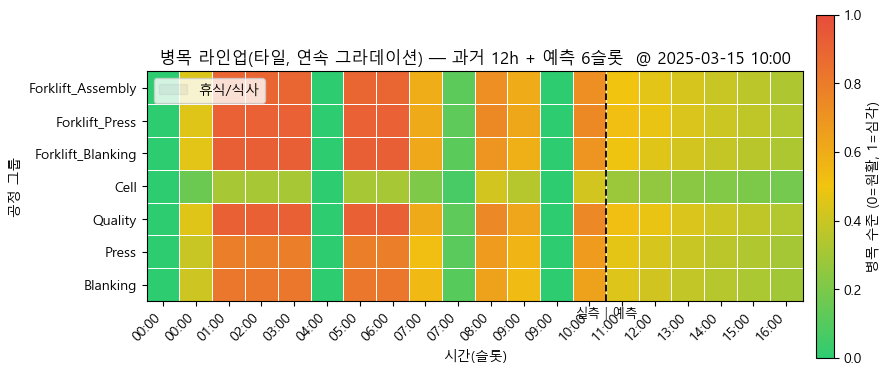

In [11]:
# =========================
# 6) 라인업 보드 — 타일(연속 그라데이션) : 실측+예측 결합, 휴게 음영, 흰색 그리드
# =========================
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 보기 창: 과거 최소 12시간 + 예측 FUT_LINEUP_SLOTS
WINDOW_HOURS = max(PAST_HOURS, 12)

board = day_df.copy()
board["t"] = board["Time_Now"]

# 슬롯 간격 추정(모드)
slot_delta = (board["Time_End"] - board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# ---- 실측 구간(과거 WINDOW_HOURS) ----
past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=WINDOW_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# ---- 예측(EMA+감쇠) ----
hist = board[board["t"] <= THOUR].tail(8)
pred_times = [THOUR + (k+1)*slot_delta for k in range(FUT_LINEUP_SLOTS)]
pred = pd.DataFrame({"t": pred_times})
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)  # 예측값 0~1 가정

# ---- 실측+예측 결합 타임라인 ----
timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M = len(groups); N = len(timeline_times)

# 값 매트릭스(0~1 연속값): 행=그룹, 열=슬롯
mat = np.zeros((M, N), dtype=float)
for i, g in enumerate(groups):
    col = valid_groups[g]
    # 실측
    if len(past) > 0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).clip(0, 1).values
    # 예측
    yhat = np.asarray(pred[display_name[g]], float)
    mat[i, len(past):] = np.clip(yhat, 0, 1)

# ---- 연속 그라데이션 컬러맵 (초록 → 노랑 → 빨강) ----
# 부드럽고 자연스런 톤으로 조정
cmap = LinearSegmentedColormap.from_list(
    "green_yellow_red",
    ["#2ecc71", "#f1c40f", "#e74c3c"]
)  # (초록, 노랑, 빨강)
norm = Normalize(vmin=0.0, vmax=1.0)

# ---- 타일(정사각) 그리기: pcolormesh + 흰색 테두리 ----
fig_h = max(3.2, 0.6 * M)     # 그룹 수 따라 자동
fig_w = max(9.0, 0.35 * N)    # 슬롯 수 따라 자동
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# 그리드 좌표(칸 경계). 열/행 경계가 정수 위치가 되게 설정
x_edges = np.arange(N + 1)
y_edges = np.arange(M + 1)

# 행 인덱스 0이 아래쪽(원하는 순서면 그대로, 반전 원하면 mat[::-1] 사용)
quad = ax.pcolormesh(
    x_edges, y_edges, mat, cmap=cmap, norm=norm, shading="flat",
    edgecolors="white", linewidth=0.7  # ← 흰색 테두리
)
ax.set_aspect("equal")  # 정사각 칸

# y축: 그룹명(중심에 라벨)
ax.set_yticks(np.arange(M) + 0.5)
ax.set_yticklabels([display_name[g] for g in groups])

# x축: 시간 라벨(너무 많으면 샘플링)
step = max(1, N // 12)
ax.set_xticks(np.arange(N)[::step] + 0.5)
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                   rotation=45, ha="right")

# 실측/예측 경계선(열 경계 좌표계에서 past 길이가 경계)
if len(past) > 0 and len(pred) > 0:
    ax.axvline(len(past), color="black", lw=1.3, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

# 휴식/식사 음영(실측 구간에 맞춰 열 범위로 음영)
rests = rest_intervals(TDAY)
if rests:
    t_series = pd.Series(timeline_times)
    for s, e in rests:
        mask = (t_series >= s) & (t_series < e)
        idxs = np.where(mask)[0]
        if len(idxs) > 0:
            x0, x1 = idxs[0], idxs[-1] + 1  # 경계좌표(왼쪽 포함, 오른쪽 경계 +1)
            ax.axvspan(x0, x1, color="grey", alpha=0.10, zorder=0)
    # 범례(휴식/식사)
    handles, labels_ = ax.get_legend_handles_labels()
    if "휴식/식사" not in labels_:
        handles.append(Patch(color="grey", alpha=0.10, label="휴식/식사"))
        ax.legend(handles=handles, loc="upper left")

# 컬러바(연속값): 0=원활, 1=심각
cb = fig.colorbar(quad, ax=ax, fraction=0.025, pad=0.02)
cb.set_label("병목 수준 (0=원활, 1=심각)")

ax.set_title(f"병목 라인업(타일, 연속 그라데이션) — 과거 {WINDOW_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯  @ {THOUR:%Y-%m-%d %H:%M}")
ax.set_xlabel("시간(슬롯)")
ax.set_ylabel("공정 그룹")
ax.grid(False)
fig.tight_layout()
plt.show()

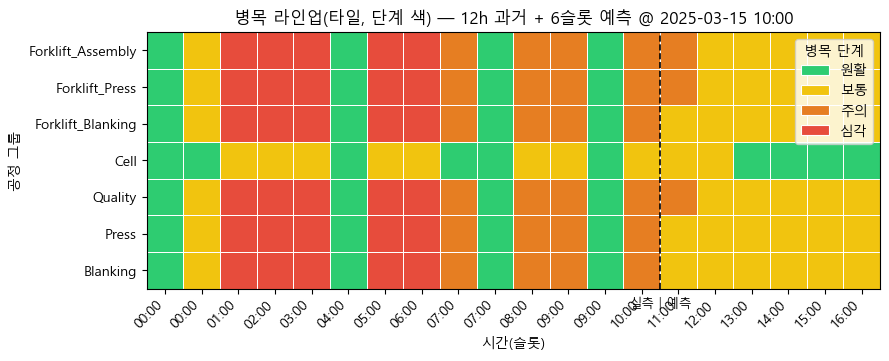

In [14]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 병목 라인업 (단계별 색상)
- Paint/Cell=0 제외, Warehouse는 Cell로 표기
- 과거 + 예측 슬롯을 타일로 표현 (단계 색상: 원활/보통/주의/심각)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

# 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# 단계 구간 & 색상
STAGE_BINS   = [0.0, 0.25, 0.5, 0.75, 1.0]
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]  # green → yellow → orange → red

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """EMA 기반 예측"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

# =========================
# 3) 데이터 로드 & 그룹 정규화
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking")],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],
    "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],
    "Quality":    [c for c in queue_cols if "quality" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly": [c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum()==0: continue
    if df[f"{g}_Qsum"].sum()==0: continue
    gmin, gmax = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
    df[f"{g}_Qnorm"] = 0.0 if gmax==gmin else (df[f"{g}_Qsum"]-gmin)/(gmax-gmin)
    valid_groups[g] = f"{g}_Qnorm"

# 표시 이름 (Warehouse → Cell)
display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# =========================
# 4) 라인업 타일 (단계별 색상)
# =========================
TDAY = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()

if not day_df.empty:
    board = day_df.copy()
    board["t"] = board["Time_Now"]

    # 과거 구간
    slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)
    past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
    past = board[past_mask].copy().reset_index(drop=True)

    # 예측
    hist = board[board["t"] <= THOUR].tail(8)
    pred_times = [THOUR + (k+1)*slot_delta for k in range(FUT_LINEUP_SLOTS)]
    pred = pd.DataFrame({"t": pred_times})
    for g,col in valid_groups.items():
        series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
        pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

    # 결합 행렬
    timeline_times = list(past["t"].values) + pred["t"].tolist()
    groups = list(valid_groups.keys())
    M, N = len(groups), len(timeline_times)
    mat = np.zeros((M,N))
    for i,g in enumerate(groups):
        col = valid_groups[g]
        if len(past)>0:
            mat[i,:len(past)] = past[col].fillna(0.0).clip(0,1).values
        mat[i,len(past):] = np.clip(np.asarray(pred[display_name[g]],float),0,1)

    # 단계별 색 매핑
    mat_stage = np.zeros_like(mat, dtype=int)
    for i in range(len(STAGE_BINS)-1):
        mask = (mat >= STAGE_BINS[i]) & (mat < STAGE_BINS[i+1])
        mat_stage[mask] = i

    # 플롯
    fig, ax = plt.subplots(figsize=(max(9,0.4*N), max(3,0.6*M)))
    cmap = mpl.colors.ListedColormap(STAGE_COLORS)
    bounds = np.arange(len(STAGE_LABELS)+1)-0.5
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    x_edges = np.arange(N+1); y_edges=np.arange(M+1)
    quad=ax.pcolormesh(x_edges,y_edges,mat_stage,cmap=cmap,norm=norm,
                       edgecolors="white",linewidth=0.7,shading="flat")
    ax.set_aspect("equal")

    ax.set_yticks(np.arange(M)+0.5); ax.set_yticklabels([display_name[g] for g in groups])
    step = max(1,N//12)
    ax.set_xticks(np.arange(N)[::step]+0.5)
    ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                       rotation=45,ha="right")

    if len(past)>0 and len(pred)>0:
        ax.axvline(len(past),color="black",lw=1.2,ls="--")
        ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

    # 범례 (단계 색)
    legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
    leg = ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")
    for ph in leg.get_patches():
        ph.set_linewidth(0.8); ph.set_edgecolor("white")

    ax.set_title(f"병목 라인업(타일, 단계 색) — {PAST_HOURS}h 과거 + {FUT_LINEUP_SLOTS}슬롯 예측 @ {THOUR:%Y-%m-%d %H:%M}")
    ax.set_xlabel("시간(슬롯)"); ax.set_ylabel("공정 그룹")
    plt.tight_layout(); plt.show()
else:
    print(f"[참고] {TDAY.date()} 데이터가 없습니다.")

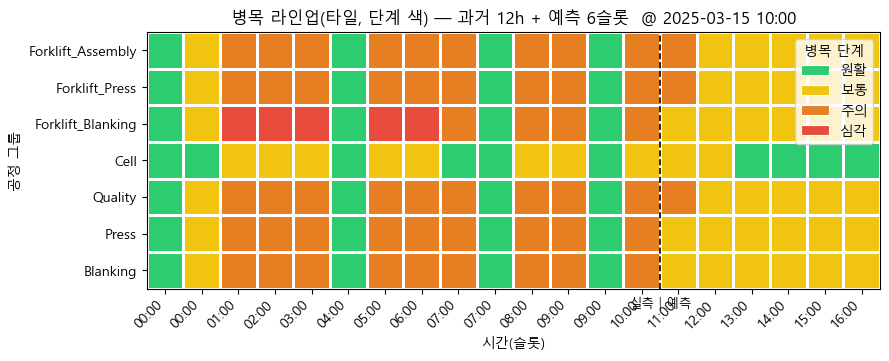

In [15]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 병목 라인업 (단계별 색상, '심각'은 시간별 1개만)
- Paint/Cell=0 제외, Warehouse는 Cell로 표기
- 과거 + 예측 슬롯을 타일로 표현
- 단계 색상: 원활/보통/주의/심각 (단, '심각'은 같은 시각에 1개 그룹만 허용)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

# 예측 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# 단계 구간 & 색상
STAGE_BINS   = [0.0, 0.25, 0.5, 0.75, 1.0]      # 0~0.25 원활, 0.25~0.5 보통, 0.5~0.75 주의, 0.75~1.0 심각
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]  # green → yellow → orange → red

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """EMA 기반 간단 예측 (감쇠)"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

# =========================
# 3) 데이터 로드 & 그룹 정규화
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다.")

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if c.lower().startswith("blanking") or c.lower()=="blanking_queue"],
    "Press":      [c for c in queue_cols if c.lower().startswith("press")],
    "Cell":       [c for c in queue_cols if c.lower().startswith("cell")],
    "Paint":      [c for c in queue_cols if c.lower().startswith("paint")],
    "Quality":    [c for c in queue_cols if "quality" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    # Paint/Cell이 전부 0이면 제외
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum()==0: 
        continue
    if df[f"{g}_Qsum"].sum()==0:
        continue
    gmin, gmax = df[f"{g}_Qsum"].min(), df[f"{g}_Qsum"].max()
    df[f"{g}_Qnorm"] = 0.0 if gmax==gmin else (df[f"{g}_Qsum"]-gmin)/(gmax-gmin)
    valid_groups[g] = f"{g}_Qnorm"

# 화면 표기: Warehouse → Cell
display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# =========================
# 4) 라인업 타일 (단계 색, '심각'은 시간별 1개만)
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()

if day_df.empty:
    raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

board = day_df.copy()
board["t"] = board["Time_Now"]

# 슬롯 간격(모드)
slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# 과거 구간 (최소 12시간 권장)
past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# 예측 (EMA+감쇠)
hist = board[board["t"] <= THOUR].tail(8)
pred_times = [THOUR + (k+1)*slot_delta for k in range(FUT_LINEUP_SLOTS)]
pred = pd.DataFrame({"t": pred_times})
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

# 결합 행렬 (값 0~1)
timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M, N = len(groups), len(timeline_times)
mat = np.zeros((M, N))
for i, g in enumerate(groups):
    col = valid_groups[g]
    if len(past)>0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).clip(0,1).values
    mat[i, len(past):] = np.clip(np.asarray(pred[display_name[g]], float), 0, 1)

# 1차 단계 배정
mat_stage = np.zeros_like(mat, dtype=int)
for k in range(len(STAGE_BINS)-1):
    mask = (mat >= STAGE_BINS[k]) & (mat < STAGE_BINS[k+1])
    mat_stage[mask] = k
severe_idx = len(STAGE_LABELS) - 1
severe_floor = STAGE_BINS[-2]  # 심각 하한 (예: 0.75)

# === '심각'은 시간별 1개만 강제 ===
for j in range(N):
    col_vals = mat[:, j]
    # 현재 '심각'으로 올라온 셀들 전부 '주의'로 내림(임시)
    mat_stage[:, j] = np.where(mat_stage[:, j] == severe_idx, severe_idx - 1, mat_stage[:, j])
    # 해당 시간의 최대값 인덱스
    i_max = int(np.nanargmax(col_vals))
    # 최대값이 심각 하한을 넘으면 그 하나만 '심각'으로 승급
    if col_vals[i_max] >= severe_floor:
        mat_stage[i_max, j] = severe_idx

# 플롯
fig, ax = plt.subplots(figsize=(max(9, 0.4*N), max(3, 0.6*M)))
cmap = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = np.arange(len(STAGE_LABELS)+1) - 0.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N + 1)
y_edges = np.arange(M + 1)
quad = ax.pcolormesh(
    x_edges, y_edges, mat_stage, cmap=cmap, norm=norm,
    edgecolors="white", linewidth=0.8, shading="flat"
)
ax.set_aspect("equal")  # 정사각 타일

# 축 라벨
ax.set_yticks(np.arange(M) + 0.5)
ax.set_yticklabels([display_name[g] for g in groups])
step = max(1, N // 12)
ax.set_xticks(np.arange(N)[::step] + 0.5)
ax.set_xticklabels(
    [pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
    rotation=45, ha="right"
)

# 실측/예측 경계선
if len(past) > 0 and len(pred) > 0:
    ax.axvline(len(past), color="black", lw=1.2, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

# 범례
legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
leg = ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")
# (matplotlib 버전에 따라 get_patches 사용)
for ph in leg.get_patches():
    ph.set_linewidth(0.8)
    ph.set_edgecolor("white")

ax.set_title(f"병목 라인업(타일, 단계 색) — 과거 {PAST_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯  @ {THOUR:%Y-%m-%d %H:%M}")
ax.set_xlabel("시간(슬롯)")
ax.set_ylabel("공정 그룹")
plt.tight_layout()
plt.show()

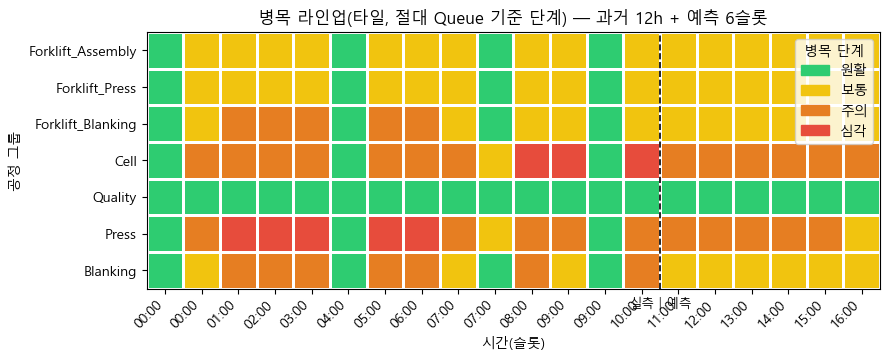

In [16]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 병목 라인업 (절대 Queue 기준 단계 색상, '심각'은 시간별 1개만)
- Paint/Cell=0 제외, Warehouse는 Cell로 표기
- 과거 + 예측 슬롯을 타일로 표현
- 단계 색상: 원활/보통/주의/심각 (단, '심각'은 같은 시각에 1개 그룹만 허용)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# === 절대 Queue 기준 단계 ===
STAGE_BINS   = [0, 100, 300, 600, np.inf]  
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """EMA 기반 간단 예측 (감쇠)"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

# =========================
# 3) 데이터 로드 & 그룹
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다.")

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if "blanking" in c.lower()],
    "Press":      [c for c in queue_cols if "press" in c.lower()],
    "Cell":       [c for c in queue_cols if "cell" in c.lower()],
    "Paint":      [c for c in queue_cols if "paint" in c.lower()],
    "Quality":    [c for c in queue_cols if "quality" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum()==0: 
        continue
    if df[f"{g}_Qsum"].sum()==0:
        continue
    valid_groups[g] = f"{g}_Qsum"   # ← 정규화 대신 합계 그대로 사용

display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# =========================
# 4) 라인업 타일 (절대 Queue 값 기반 단계)
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()
if day_df.empty:
    raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

board = day_df.copy(); board["t"] = board["Time_Now"]

slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# 예측 (EMA)
hist = board[board["t"] <= THOUR].tail(8)
pred_times = [THOUR + (k+1)*slot_delta for k in range(FUT_LINEUP_SLOTS)]
pred = pd.DataFrame({"t": pred_times})
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M, N = len(groups), len(timeline_times)

mat = np.zeros((M, N))
for i, g in enumerate(groups):
    col = valid_groups[g]
    if len(past)>0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).values
    mat[i, len(past):] = np.asarray(pred[display_name[g]], float)

# 단계 배정
mat_stage = np.zeros_like(mat, dtype=int)
for k in range(len(STAGE_BINS)-1):
    mask = (mat >= STAGE_BINS[k]) & (mat < STAGE_BINS[k+1])
    mat_stage[mask] = k

# '심각'은 시간별 1개만
severe_idx = len(STAGE_LABELS) - 1
severe_floor = STAGE_BINS[-2]
for j in range(N):
    col_vals = mat[:, j]
    mat_stage[:, j] = np.where(mat_stage[:, j] == severe_idx, severe_idx - 1, mat_stage[:, j])
    i_max = int(np.nanargmax(col_vals))
    if col_vals[i_max] >= severe_floor:
        mat_stage[i_max, j] = severe_idx

# 시각화
fig, ax = plt.subplots(figsize=(max(9, 0.4*N), max(3, 0.6*M)))
cmap = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = np.arange(len(STAGE_LABELS)+1) - 0.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N+1); y_edges = np.arange(M+1)
quad = ax.pcolormesh(x_edges, y_edges, mat_stage, cmap=cmap, norm=norm,
                     edgecolors="white", linewidth=0.8, shading="flat")
ax.set_aspect("equal")

ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels([display_name[g] for g in groups])
step = max(1, N//12)
ax.set_xticks(np.arange(N)[::step]+0.5)
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                   rotation=45, ha="right")

if len(past)>0 and len(pred)>0:
    ax.axvline(len(past), color="black", lw=1.2, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")

ax.set_title(f"병목 라인업(타일, 절대 Queue 기준 단계) — 과거 {PAST_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯")
ax.set_xlabel("시간(슬롯)"); ax.set_ylabel("공정 그룹")
plt.tight_layout(); plt.show()


[‘심각’ 미표기 시간대 사유]
- 00:00 : 최대값 임계 미달
- 00:00 : 최대값 임계 미달
- 04:00 : 최대값 임계 미달
- 07:00 : 최대값 임계 미달
- 07:00 : 최대값 임계 미달
- 09:00 : 최대값 임계 미달
- 11:00 : 최대값 임계 미달
- 12:00 : 휴식/식사
- 13:00 : 최대값 임계 미달
- 14:00 : 최대값 임계 미달
- 15:00 : 최대값 임계 미달
- 16:00 : 최대값 임계 미달


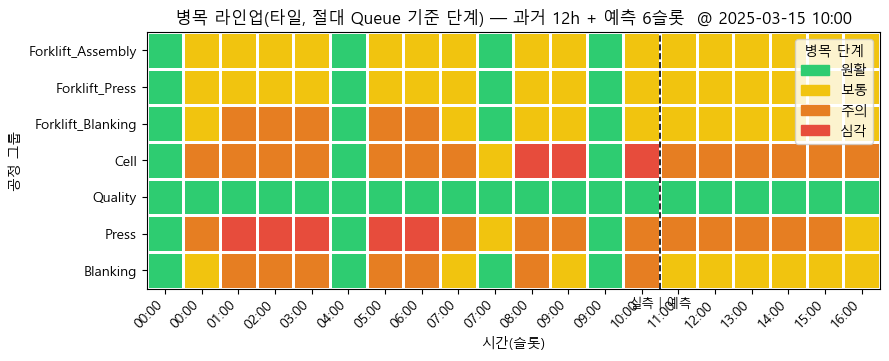

In [17]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 병목 라인업 (절대 Queue 기준 단계 색상, '심각'은 시간별 1개만)
- Paint/Cell=0 제외, Warehouse는 Cell로 표기
- 과거 + 예측 슬롯을 타일로 표현
- 단계 색상: 원활/보통/주의/심각 (단, '심각'은 같은 시각에 1개 그룹만 허용)
- 개선점:
  1) 예측 시작 시각을 과거 마지막 슬롯 이후로 시작 → 중복 타임스탬프 제거
  2) '심각' 미표기 시간대 사유 콘솔 요약(휴식/식사 or 임계 미달)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# === 절대 Queue 기준 단계 (필요시 조정) ===
STAGE_BINS   = [0, 100, 300, 600, np.inf]  # 0~<100 원활, 100~<300 보통, 300~<600 주의, 600~ 심각
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]

# 휴식/식사 스케줄 (07:50 ~ 다음날 07:40 창)
SCHEDULE_BLOCKS = [
    ("07:50","09:50","주간"),
    ("09:50","10:00","휴식"),
    ("10:00","11:50","주간"),
    ("11:50","12:40","중식"),
    ("12:40","14:40","주간"),
    ("14:40","14:50","휴식"),
    ("14:50","16:40","주간"),
    ("16:40","17:10","석식"),
    ("17:10","20:10","잔업"),
    ("20:10","20:40","휴식"),
    ("20:40","00:00","야간"),
    ("00:00","00:30","야식"),
    ("00:30","04:00","야간"),
    ("04:00","05:00","휴식"),
    ("05:00","07:40","야간"),
]
REST_LABELS = {"휴식","중식","석식","야식"}

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """EMA 기반 간단 예측 (감쇠)"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

def build_schedule_for_plot(day: pd.Timestamp) -> pd.DataFrame:
    """스케줄을 실제 날짜 범위(07:50~다음날 07:40)에 맞춰 타임스탬프화"""
    day = pd.Timestamp(day).floor("D")
    anchor_start = pd.Timestamp(day.year,day.month,day.day,7,50)
    anchor_end   = anchor_start + pd.Timedelta(hours=23, minutes=50)  # 다음날 07:40
    rows=[]
    for sstr, estr, label in SCHEDULE_BLOCKS:
        sh,sm = map(int, sstr.split(":"))
        eh,em = map(int, estr.split(":"))
        s = pd.Timestamp(day.year,day.month,day.day,sh,sm)
        e = pd.Timestamp(day.year,day.month,day.day,eh,em)
        if (sh,sm) < (7,50): s += pd.Timedelta(days=1)
        if (eh,em) < (7,50) or e <= s: e += pd.Timedelta(days=1)
        s = max(s, anchor_start); e = min(e, anchor_end)
        if e > s: rows.append({"start":s,"end":e,"label":label})
    return pd.DataFrame(rows)

def rest_intervals(day: pd.Timestamp):
    """휴식/식사 구간 병합"""
    sch = build_schedule_for_plot(day)
    rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]].sort_values("start")
    merged=[]
    if rest.empty: return merged
    cur_s, cur_e = rest.iloc[0]["start"], rest.iloc[0]["end"]
    for _, r in rest.iloc[1:].iterrows():
        s, e = r["start"], r["end"]
        if s <= cur_e: cur_e = max(cur_e, e)
        else: merged.append((cur_s, cur_e)); cur_s, cur_e = s, e
    merged.append((cur_s, cur_e))
    return merged

def shade_rest(ax, intervals, label="휴식/식사"):
    if not intervals: return
    for s,e in intervals:
        ax.axvspan(s, e, color="grey", alpha=0.12, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    if label not in labels:
        handles.append(Patch(color="grey", alpha=0.12, label=label))
        ax.legend(handles=handles, loc="best")

# =========================
# 3) 데이터 로드 & 그룹 (절대 Queue 사용)
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다.")

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if "blanking" in c.lower()],
    "Press":      [c for c in queue_cols if "press" in c.lower()],
    "Cell":       [c for c in queue_cols if "cell" in c.lower()],
    "Paint":      [c for c in queue_cols if "paint" in c.lower()],
    "Quality":    [c for c in queue_cols if "quality" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    # Paint/Cell 전부 0이면 제거
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum()==0:
        continue
    if df[f"{g}_Qsum"].sum()==0:
        continue
    valid_groups[g] = f"{g}_Qsum"   # ← 정규화 NO, 절대값 사용

display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# =========================
# 4) 라인업 타일 (절대 Queue 단계, '심각' 시간당 1개)
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()
if day_df.empty:
    raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

board = day_df.copy(); board["t"] = board["Time_Now"]

# 슬롯 간격(모드)
slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# 과거 구간
past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# 예측 시작시각: 과거 마지막 슬롯 이후로(중복 제거)
last_t = past["t"].iloc[-1] if len(past)>0 else THOUR
pred_times = [last_t + k*slot_delta for k in range(1, FUT_LINEUP_SLOTS+1)]
pred = pd.DataFrame({"t": pred_times})

# 예측 값(EMA)
hist = board[board["t"] <= THOUR].tail(8)
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

# 타임라인 조립
timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M, N = len(groups), len(timeline_times)

# 절대 Queue 행렬
mat = np.zeros((M, N))
for i, g in enumerate(groups):
    col = valid_groups[g]
    if len(past)>0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).values
    mat[i, len(past):] = np.asarray(pred[display_name[g]], float)

# 단계 행렬 (절대 bins)
mat_stage = np.zeros_like(mat, dtype=int)
for k in range(len(STAGE_BINS)-1):
    mask = (mat >= STAGE_BINS[k]) & (mat < STAGE_BINS[k+1])
    mat_stage[mask] = k

# '심각'은 시간별 1개만
severe_idx = len(STAGE_LABELS) - 1
severe_floor = STAGE_BINS[-2]  # 예: 600
for j in range(N):
    col_vals = mat[:, j]
    # 임시로 '심각' 내림
    mat_stage[:, j] = np.where(mat_stage[:, j] == severe_idx, severe_idx - 1, mat_stage[:, j])
    # 최대값 하나만 심각으로 승급 (최대가 하한 이상일 때)
    i_max = int(np.nanargmax(col_vals))
    if col_vals[i_max] >= severe_floor:
        mat_stage[i_max, j] = severe_idx

# ---- 휴식/식사 여부를 시간축에 매핑 (사유 출력용) ----
rests = rest_intervals(TDAY)
t_series = pd.Series(timeline_times)
is_rest_col = np.zeros(N, dtype=bool)
for (rs, re) in rests:
    mask = (t_series >= rs) & (t_series < re)
    is_rest_col |= mask.values

# ---- ‘심각’ 미표기 시간대 사유 요약 출력 ----
no_severe_cols = []
for j in range(N):
    if not np.any(mat_stage[:, j] == severe_idx):
        reason = "휴식/식사" if is_rest_col[j] else "최대값 임계 미달"
        no_severe_cols.append((pd.to_datetime(timeline_times[j]).strftime("%H:%M"), reason))

if no_severe_cols:
    print("\n[‘심각’ 미표기 시간대 사유]")
    for tm, why in no_severe_cols:
        print(f"- {tm} : {why}")
else:
    print("\n모든 시간대에서 최소 1개 공정이 ‘심각’으로 표기되었습니다.")

# ---- 시각화 ----
fig, ax = plt.subplots(figsize=(max(9, 0.4*N), max(3, 0.6*M)))
cmap = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = np.arange(len(STAGE_LABELS)+1) - 0.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N+1); y_edges = np.arange(M+1)
quad = ax.pcolormesh(x_edges, y_edges, mat_stage, cmap=cmap, norm=norm,
                     edgecolors="white", linewidth=0.8, shading="flat")
ax.set_aspect("equal")

# 축 라벨
ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels([display_name[g] for g in groups])
step = max(1, N//12)
ax.set_xticks(np.arange(N)[::step]+0.5)
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                   rotation=45, ha="right")

# 실측/예측 경계
if len(past)>0 and len(pred)>0:
    ax.axvline(len(past), color="black", lw=1.2, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

# 휴식/식사 음영(시간축 기준)
for s, e in rests:
    # pcolormesh 좌표계(x=컬럼 인덱스)로 변환
    mask = (t_series >= s) & (t_series < e)
    idxs = np.where(mask)[0]
    if len(idxs) > 0:
        ax.axvspan(idxs[0], idxs[-1]+1, color="grey", alpha=0.09, zorder=0)

# 범례
legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")

ax.set_title(f"병목 라인업(타일, 절대 Queue 기준 단계) — 과거 {PAST_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯  @ {THOUR:%Y-%m-%d %H:%M}")
ax.set_xlabel("시간(슬롯)"); ax.set_ylabel("공정 그룹")
plt.tight_layout(); plt.show()

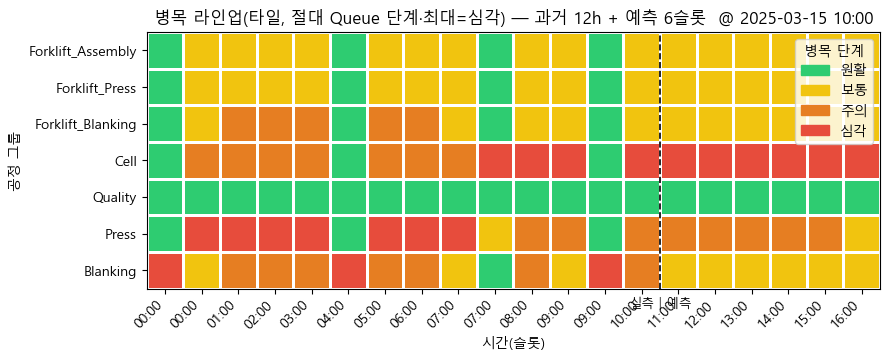

In [18]:
# -*- coding: utf-8 -*-
"""
시간별 Queue CSV 기반 병목 라인업 (절대 Queue 기준 단계 색상, '심각'은 시간별 1개 고정)
- Paint/Cell=0 제외, Warehouse는 Cell로 표기
- 과거 + 예측 슬롯을 타일로 표현
- 단계 색상: 원활/보통/주의/심각
- 변경점: '심각'은 임계값 없이, 각 시간대의 '최댓값 1개'를 무조건 지정
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# =========================
# 0) 설정
# =========================
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

TARGET_DATE = "2025-03-15"
TARGET_HOUR = "2025-03-15 10:00"

# 예측 파라미터
EMA_ALPHA = 0.4
DECAY     = 0.92
PAST_HOURS = 12
FUT_LINEUP_SLOTS = 6

# 절대 Queue 기준 단계 구간(필요 시 조정 가능)
STAGE_BINS   = [0, 100, 300, 600, np.inf]                 # 0~<100 원활, 100~<300 보통, 300~<600 주의, ≥600 심각
STAGE_LABELS = ["원활", "보통", "주의", "심각"]
STAGE_COLORS = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]

# 휴식/식사 스케줄 (07:50 ~ 다음날 07:40 창)
SCHEDULE_BLOCKS = [
    ("07:50","09:50","주간"),
    ("09:50","10:00","휴식"),
    ("10:00","11:50","주간"),
    ("11:50","12:40","중식"),
    ("12:40","14:40","주간"),
    ("14:40","14:50","휴식"),
    ("14:50","16:40","주간"),
    ("16:40","17:10","석식"),
    ("17:10","20:10","잔업"),
    ("20:10","20:40","휴식"),
    ("20:40","00:00","야간"),
    ("00:00","00:30","야식"),
    ("00:30","04:00","야간"),
    ("04:00","05:00","휴식"),
    ("05:00","07:40","야간"),
]
REST_LABELS = {"휴식","중식","석식","야식"}

# =========================
# 1) 폰트(한글)
# =========================
def set_korean_font():
    mpl.rcParams["axes.unicode_minus"] = False
    cand = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fontManager.ttflist}
    for n in cand:
        if n in avail:
            mpl.rcParams["font.family"] = n
            return
set_korean_font()

# =========================
# 2) 유틸
# =========================
def ema_next(series, alpha=EMA_ALPHA, steps=1, decay=DECAY):
    """EMA 기반 간단 예측 (감쇠)"""
    if len(series)==0: return [0.0]*steps
    ema = series[0]
    for v in series[1:]:
        ema = alpha*v + (1-alpha)*ema
    return [float(ema * (decay**k)) for k in range(steps)]

def build_schedule_for_plot(day: pd.Timestamp) -> pd.DataFrame:
    """스케줄을 실제 날짜 범위(07:50~다음날 07:40)에 맞춰 타임스탬프화"""
    day = pd.Timestamp(day).floor("D")
    anchor_start = pd.Timestamp(day.year,day.month,day.day,7,50)
    anchor_end   = anchor_start + pd.Timedelta(hours=23, minutes=50)  # 다음날 07:40
    rows=[]
    for sstr, estr, label in SCHEDULE_BLOCKS:
        sh,sm = map(int, sstr.split(":"))
        eh,em = map(int, estr.split(":"))
        s = pd.Timestamp(day.year,day.month,day.day,sh,sm)
        e = pd.Timestamp(day.year,day.month,day.day,eh,em)
        if (sh,sm) < (7,50): s += pd.Timedelta(days=1)
        if (eh,em) < (7,50) or e <= s: e += pd.Timedelta(days=1)
        s = max(s, anchor_start); e = min(e, anchor_end)
        if e > s: rows.append({"start":s,"end":e,"label":label})
    return pd.DataFrame(rows)

def rest_intervals(day: pd.Timestamp):
    """휴식/식사 구간 병합"""
    sch = build_schedule_for_plot(day)
    rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]].sort_values("start")
    merged=[]
    if rest.empty: return merged
    cur_s, cur_e = rest.iloc[0]["start"], rest.iloc[0]["end"]
    for _, r in rest.iloc[1:].iterrows():
        s, e = r["start"], r["end"]
        if s <= cur_e: cur_e = max(cur_e, e)
        else: merged.append((cur_s, cur_e)); cur_s, cur_e = s, e
    merged.append((cur_s, cur_e))
    return merged

# =========================
# 3) 데이터 로드 & 그룹 (절대 Queue 사용)
# =========================
df = pd.read_csv(CSV_PATH, low_memory=False)
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["Time_End"] = pd.to_datetime(df["Time_End"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
if not queue_cols:
    raise ValueError("*_Queue 컬럼이 없습니다.")

GROUP_MAP = {
    "Blanking":   [c for c in queue_cols if "blanking" in c.lower()],
    "Press":      [c for c in queue_cols if "press" in c.lower()],
    "Cell":       [c for c in queue_cols if "cell" in c.lower()],
    "Paint":      [c for c in queue_cols if "paint" in c.lower()],
    "Quality":    [c for c in queue_cols if "quality" in c.lower()],
    "Warehouse":  [c for c in queue_cols if "warehouse" in c.lower()],
    "Forklift_Blanking": [c for c in queue_cols if "forklift_blanking" in c.lower()],
    "Forklift_Press":    [c for c in queue_cols if "forklift_press" in c.lower()],
    "Forklift_Assembly":[c for c in queue_cols if "forklift_assembly" in c.lower()],
}
GROUP_MAP = {g: cols for g, cols in GROUP_MAP.items() if cols}

valid_groups = {}
for g, cols in GROUP_MAP.items():
    df[f"{g}_Qsum"] = df[cols].sum(axis=1)
    # Paint/Cell 전부 0이면 제거
    if g in ("Paint","Cell") and df[f"{g}_Qsum"].sum()==0:
        continue
    if df[f"{g}_Qsum"].sum()==0:
        continue
    valid_groups[g] = f"{g}_Qsum"   # 절대값 사용

# 화면 표기: Warehouse → Cell
display_name = {g: ("Cell" if g=="Warehouse" else g) for g in valid_groups}

# =========================
# 4) 라인업 타일 (절대 Queue 단계, '심각' 시간당 1개: 최댓값 지정)
# =========================
TDAY  = pd.Timestamp(TARGET_DATE).floor("D")
THOUR = pd.Timestamp(TARGET_HOUR)
day_df = df[df["_date"]==TDAY].copy()
if day_df.empty:
    raise ValueError(f"{TDAY.date()} 날짜 데이터가 없습니다.")

board = day_df.copy(); board["t"] = board["Time_Now"]

# 슬롯 간격(모드)
slot_delta = (board["Time_End"]-board["Time_Now"]).mode().iloc[0] if not board.empty else pd.Timedelta(minutes=60)

# 과거 구간
past_mask = (board["t"] <= THOUR) & (board["t"] >= THOUR - pd.Timedelta(hours=PAST_HOURS))
past = board[past_mask].copy().reset_index(drop=True)

# 예측 시작시각: 과거 마지막 슬롯 이후로(중복 제거)
last_t = past["t"].iloc[-1] if len(past)>0 else THOUR
pred_times = [last_t + k*slot_delta for k in range(1, FUT_LINEUP_SLOTS+1)]
pred = pd.DataFrame({"t": pred_times})

# 예측 값(EMA, 절대 Queue 스케일 추정: 최근 값의 EMA를 그대로 이어감)
hist = board[board["t"] <= THOUR].tail(8)
for g, col in valid_groups.items():
    series = hist[col].astype(float).fillna(method="ffill").fillna(0.0).values
    pred[display_name[g]] = ema_next(series, EMA_ALPHA, FUT_LINEUP_SLOTS, DECAY)

# 타임라인 조립
timeline_times = list(past["t"].values) + pred["t"].tolist()
groups = list(valid_groups.keys())
M, N = len(groups), len(timeline_times)

# 절대 Queue 행렬
mat = np.zeros((M, N))
for i, g in enumerate(groups):
    col = valid_groups[g]
    if len(past)>0:
        mat[i, :len(past)] = past[col].astype(float).fillna(0.0).values
    mat[i, len(past):] = np.asarray(pred[display_name[g]], float)

# 단계 행렬 (절대 bins)
mat_stage = np.zeros_like(mat, dtype=int)
for k in range(len(STAGE_BINS)-1):
    mask = (mat >= STAGE_BINS[k]) & (mat < STAGE_BINS[k+1])
    mat_stage[mask] = k

# === '심각'은 시간별 '최댓값 1개'로 강제 지정 (임계/하한 X) ===
severe_idx = len(STAGE_LABELS) - 1
for j in range(N):
    # 일단 모두 '심각'을 원래 단계로 초기화(혹시 이전 로직 잔여가 있을 수 있어 클리어)
    mat_stage[:, j] = np.where(mat_stage[:, j] == severe_idx, severe_idx - 1, mat_stage[:, j])
    # 최댓값 위치 하나만 '심각'
    i_max = int(np.nanargmax(mat[:, j]))
    mat_stage[i_max, j] = severe_idx

# 시각화
fig, ax = plt.subplots(figsize=(max(9, 0.4*N), max(3, 0.6*M)))
cmap = mpl.colors.ListedColormap(STAGE_COLORS)
bounds = np.arange(len(STAGE_LABELS)+1) - 0.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

x_edges = np.arange(N+1); y_edges = np.arange(M+1)
quad = ax.pcolormesh(x_edges, y_edges, mat_stage, cmap=cmap, norm=norm,
                     edgecolors="white", linewidth=0.8, shading="flat")
ax.set_aspect("equal")

# 축 라벨
ax.set_yticks(np.arange(M)+0.5)
ax.set_yticklabels([display_name[g] for g in groups])
step = max(1, N//12)
ax.set_xticks(np.arange(N)[::step]+0.5)
ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in timeline_times][::step],
                   rotation=45, ha="right")

# 실측/예측 경계
if len(past)>0 and len(pred)>0:
    ax.axvline(len(past), color="black", lw=1.2, ls="--")
    ax.text(len(past), -0.6, "실측│예측", ha="center", va="bottom", fontsize=9)

# 휴식/식사 음영(시간축 기준)
rests = rest_intervals(TDAY)
t_series = pd.Series(timeline_times)
for s, e in rests:
    mask = (t_series >= s) & (t_series < e)
    idxs = np.where(mask)[0]
    if len(idxs) > 0:
        ax.axvspan(idxs[0], idxs[-1]+1, color="grey", alpha=0.09, zorder=0)

# 범례
legend_handles = [Patch(color=STAGE_COLORS[i], label=STAGE_LABELS[i]) for i in range(len(STAGE_LABELS))]
ax.legend(handles=legend_handles, loc="upper right", title="병목 단계")

ax.set_title(f"병목 라인업(타일, 절대 Queue 단계·최대=심각) — 과거 {PAST_HOURS}h + 예측 {FUT_LINEUP_SLOTS}슬롯  @ {THOUR:%Y-%m-%d %H:%M}")
ax.set_xlabel("시간(슬롯)"); ax.set_ylabel("공정 그룹")
plt.tight_layout(); plt.show()